In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm, ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

fontsize = 14

fig_dir = 'figs/'



In [2]:
### get results from WCU reevaluation, after recauculating Pareto set with original 5 objs from MOO
# results = pd.read_csv('../results_arx/infra_wcu/objs_wcu_pareto_5objs_coarse.csv', sep=', ')
results = pd.read_csv('../results_arx/infra_wcu/objs_wcu_pareto_5objs.csv', sep=', ')

### map all costs >1000 to 1000 for visual clarity
for c in ['cog_wp_p90','cog_wp_p50','cog_p_p90','cog_p_p50']:
    results.loc[results[c] > 1000, c] = 1000
results

,label,proj,share_FRS,share_COF,share_TUL,share_KWD,share_EXE,share_LDS,share_LND,share_PRT,...,share_OTL,share_OFK,cwg_p,ap_p,cwg_np,cog_wp_p90,n_p,cog_wp_p50,cog_p_p90,cog_p_p50
0,soln1,3.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,65.286506,25.517769,23.581953,119.515925,3,89.158155,99.563570,77.701771
1,soln100,3.0,0.229613,0.0,0.0,0.028464,0.0,0.042006,0.0,0.000000,...,0.0,0.0,83.519969,60.988011,10.534398,261.605829,14,193.645286,80.755699,61.638616
2,soln1001,3.0,0.157149,0.0,0.0,0.021555,0.0,0.058443,0.0,0.015334,...,0.0,0.0,88.828797,64.907146,5.730221,1000.000000,16,250.040212,79.661088,57.443358
3,soln1004,3.0,0.184161,0.0,0.0,0.015033,0.0,0.082272,0.0,0.033642,...,0.0,0.0,92.460681,68.455763,-9.325362,1000.000000,17,234.514933,76.353268,54.874293
4,soln1005,3.0,0.230880,0.0,0.0,0.021901,0.0,0.000000,0.0,0.013729,...,0.0,0.0,92.651047,58.407270,13.067463,1000.000000,12,167.606488,78.175537,55.627771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,soln988,3.0,0.281544,0.0,0.0,0.100894,0.0,0.000000,0.0,0.000000,...,0.0,0.0,86.194462,51.207598,17.240311,218.698388,8,141.999551,78.078149,58.693952
370,soln989,3.0,0.179659,0.0,0.0,0.038620,0.0,0.000000,0.0,0.000000,...,0.0,0.0,106.223722,47.046693,-4.389908,290.474609,9,180.005108,60.848568,47.246331
371,soln995,3.0,0.194263,0.0,0.0,0.019244,0.0,0.000000,0.0,0.017592,...,0.0,0.0,77.769762,40.167874,20.107271,253.288096,11,159.968357,85.266248,63.624433
372,soln996,3.0,0.265480,0.0,0.0,0.023911,0.0,0.000000,0.0,0.026126,...,0.0,0.0,89.655118,53.916342,15.455185,225.967740,11,161.500598,73.240741,56.707781


In [3]:
shares = results.loc[:,['share' in c for c in results.columns]]
objs = results.iloc[:, -8:]
objs['proj'] = results['proj']
print(shares.columns)
print(objs.columns)

Index(['share_FRS', 'share_COF', 'share_TUL', 'share_KWD', 'share_EXE',
       'share_LDS', 'share_LND', 'share_PRT', 'share_LWT', 'share_TPD',
       'share_SAU', 'share_TBA', 'share_PIX', 'share_DLE', 'share_KRT',
       'share_SSJ', 'share_SFW', 'share_NKN', 'share_ARV', 'share_DLR',
       'share_ID4', 'share_SMI', 'share_TJC', 'share_BLR', 'share_LHL',
       'share_BDM', 'share_WRM', 'share_COB', 'share_BVA', 'share_CWO',
       'share_HML', 'share_KND', 'share_RRB', 'share_CNS', 'share_ALT',
       'share_CWC', 'share_MAD', 'share_SOC', 'share_SOB', 'share_CCA',
       'share_OTL', 'share_OFK'],
      dtype='object')
Index(['cwg_p', 'ap_p', 'cwg_np', 'cog_wp_p90', 'n_p', 'cog_wp_p50',
       'cog_p_p90', 'cog_p_p50', 'proj'],
      dtype='object')


In [4]:
ef_results = pd.read_csv('../results_arx/infra_wcu/objs_wcu_pareto_5objs_coarse_withBaselines.csv', sep=', ').iloc[-3:,:]
### map all costs >1000 to 1000 for visual clarity
for c in ['cog_wp_p90','cog_wp_p50','cog_p_p90','cog_p_p50']:
    ef_results.loc[ef_results[c] > 1000, c] = 1000
    
ef_shares = ef_results.loc[:,['share' in c for c in ef_results.columns]]
ef_objs = ef_results.iloc[:, -8:]
ef_objs['proj'] = ef_results['proj']

In [5]:
ef_results

,label,proj,share_FRS,share_COF,share_TUL,share_KWD,share_EXE,share_LDS,share_LND,share_PRT,...,share_OTL,share_OFK,cwg_p,ap_p,cwg_np,cog_wp_p90,n_p,cog_wp_p50,cog_p_p90,cog_p_p50
96,friant16,1.0,0.02289,0.061623,0.073846,0.0,0.017611,0.028244,0.040608,0.025589,...,0.000000,0.075813,50.793163,40.140243,-0.592862,1000.000000,16,1000.000000,71.834523,50.754024
97,alt3,3.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,77.502383,40.984979,6.211429,113.757334,3,86.769882,84.238906,66.701589
98,alt8,3.0,0.00000,0.000000,0.022338,0.0,0.000000,0.000000,0.000000,0.000000,...,0.149274,0.000000,44.914626,25.288021,2.640060,1000.000000,8,300.739962,243.816583,105.374187


In [6]:
# sns.pairplot(objs, hue='proj', vars=['cwg_p', 'ap_p', 'cwg_np', 'cog_wp_p90', 'n_p'])
# sns.pairplot(objs, hue='proj', vars=['cwg_p', 'ap_p', 'cwg_np', 'cog_wp_p50', 'n_p'])
# sns.pairplot(objs, hue='proj', vars=['cwg_p', 'ap_p', 'cwg_np', 'cog_p_p90', 'n_p'])
# sns.pairplot(objs, hue='proj', vars=['cwg_p', 'ap_p', 'cwg_np', 'cog_p_p50', 'n_p'])
# sns.pairplot(objs, hue='proj', vars=['cwg_p', 'ap_p', 'cwg_np', 'n_p', 'cog_wp_p90', 'cog_wp_p50', 'cog_p_p90', 'cog_p_p50'])

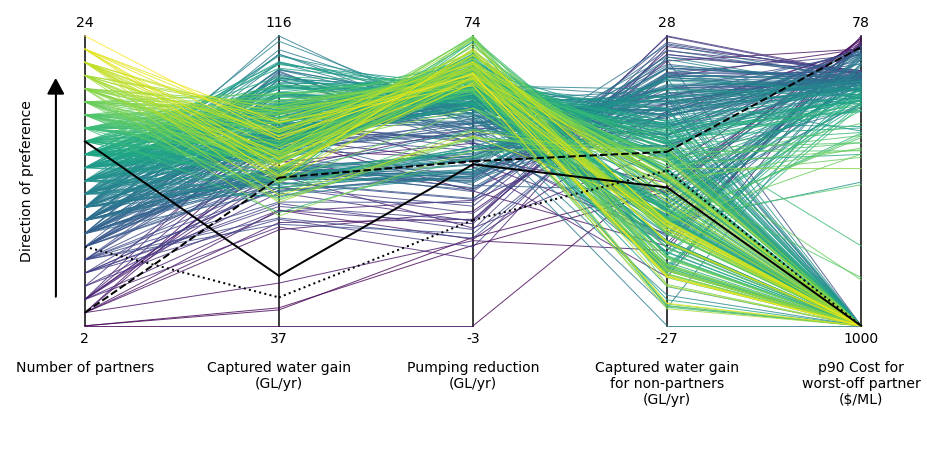

In [7]:
### reorganize for parallel coordinate plot
curvy = False

cost_type = 'cog_wp_p90'
fig_stage = 3   # 0 = axes only, 1 = friant16 only, 2 = friant16+alt3+alt8, 3 = all w/ hilite friant16+alt3+alt8, 
                #       4 = all brushed except friant16+alt3+alt8, 5 = all except friant16+alt3+alt8,
                #       6 = all w/ hilite maxs+compromise
        
ideal = 'top'

cols = ['n_p', 'cwg_p', 'ap_p', 'cwg_np', cost_type]
cost_type_labels = {'cog_wp_p90': 'p90 Cost for\nworst-off partner\n($/ML)',
                   'cog_wp_p50': 'Median cost of gains,\nworst-off\npartner\n($/ML)',
                   'cog_p_p90': '90%ile cost of gains,\npartnership\n($/ML)',
                   'cog_p_p50': 'Median cost of gains,\npartnership\n($/ML)'}
ressat = results.loc[:,cols]
ressat = ressat.append(ef_results.loc[:,cols])

ideal = 'top'


if ideal == 'bottom':
    tops = ressat.min(axis=0)
    bottoms = ressat.max(axis=0)
    switch = bottoms[-1]
    bottoms[-1] = tops[-1]
    tops[-1] = switch
    ressat.iloc[:, :-1] = (ressat.iloc[:, :-1].max(axis=0) - ressat.iloc[:, :-1]) / (ressat.iloc[:, :-1].max(axis=0) - ressat.iloc[:, :-1].min(axis=0))
    ressat.iloc[:, -1] = (ressat.iloc[:, -1] - ressat.iloc[:, -1].min(axis=0)) / (ressat.iloc[:, -1].max(axis=0) - ressat.iloc[:, -1].min(axis=0))
elif ideal == 'top':
    tops = ressat.max(axis=0)
    bottoms = ressat.min(axis=0)
    switch = bottoms[-1]
    bottoms[-1] = tops[-1]
    tops[-1] = switch
    ressat.iloc[:, -1] = (ressat.iloc[:, -1].max(axis=0) - ressat.iloc[:, -1]) / (ressat.iloc[:, -1].max(axis=0) - ressat.iloc[:, -1].min(axis=0))
    ressat.iloc[:, :-1] = (ressat.iloc[:, :-1] - ressat.iloc[:, :-1].min(axis=0)) / (ressat.iloc[:, :-1].max(axis=0) - ressat.iloc[:, :-1].min(axis=0))
else:
    print('ideal should be "top" or "bottom" based on direction of preference')
    
### parallel coord plot
fig,ax = plt.subplots(1,1,figsize=(16,8), gridspec_kw={'hspace':0.1, 'wspace':0.1})

colnorm = 0
### plot all satisficing solns
for i in range(ressat.shape[0]):
    for j in range(len(cols)-1):
        numnorm = ressat.iloc[i,colnorm]  / ressat.iloc[:,colnorm].max() #*0.9
        c = cm.get_cmap('viridis')(numnorm)
        y1 = ressat.iloc[i, j]
        y2 = ressat.iloc[i, j+1]
        if curvy:
            ### add sin shape to help distinguish lines
            t = np.arange(-np.pi/2, np.pi/2+0.001, 0.01)
            y = y1 + (np.sin(t) + 1) / 2 * (y2 - y1)
            x = j + t / np.pi + 1/2
        else:
            y = [y1, y2]
            x = [j, j+1]
        if fig_stage < 3:
            alpha = 0
        elif fig_stage in (4,6):
            alpha = 0.1
        else:
            alpha=0.8
        if i < ressat.shape[0] - 3:
            ### plot solns from MOO/WCU
            ax.plot(x, y, c=c, alpha=alpha, zorder=2+numnorm, lw=1)
        ### plot extra solns from EF paper
        if fig_stage < 5:
            lsdict = {ressat.shape[0]-3: '-', ressat.shape[0]-2: '--', ressat.shape[0]-1: ':'}
            if i == ressat.shape[0] - 3:    
                if fig_stage > 0:
                    ax.plot(x, y, c='k', alpha=1, zorder=4, lw=2, ls=lsdict[i])
            elif i > ressat.shape[0] - 3:
                if fig_stage > 1:
                    ax.plot(x, y, c='k', alpha=1, zorder=4, lw=2, ls=lsdict[i])

                    
### hilite example solns from WCU
solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = ['max_NP', 'max_CWG_P', 'min_COG_WP', 'compromise']
label_dict = {solns[i]:labels[i] for i in range(4)}
if fig_stage > 5:

    marker_dict = {solns[i]:['o', 'v', 'P', 's'][i] for i in range(4)}
    ### plot all satisficing solns
    for i in range(ressat.shape[0]-3):
        if results['label'].iloc[i] in solns:
            soln = results['label'].iloc[i]
            for j in range(len(cols)-1):
                numnorm = ressat.iloc[i,colnorm]  / ressat.iloc[:,colnorm].max() #*0.9
                c = cm.get_cmap('viridis')(numnorm)
                y1 = ressat.iloc[i, j]
                y2 = ressat.iloc[i, j+1]
                if curvy:
                    ### add sin shape to help distinguish lines
                    t = np.arange(-np.pi/2, np.pi/2+0.001, np.pi/10)
                    y = y1 + (np.sin(t) + 1) / 2 * (y2 - y1)
                    x = j + t / np.pi + 1/2
                else:
                    x = np.arange(j, j+1+0.001, 1/10)
                    y = y1 + (x - j) * (y2 - y1)
                alpha=0.8
                if j == 0:
                    ax.plot(x, y, c=c, alpha=alpha, zorder=3, lw=2.5, marker=marker_dict[soln], ms=9, label=label_dict[soln])
                else:
                    ax.plot(x, y, c=c, alpha=alpha, zorder=3, lw=2.5, marker=marker_dict[soln], ms=9)
                    
    ax.legend(ncol=4, loc='lower center')
                

### add top/bottom ranges
for j in range(len(cols)):
    ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom', zorder=5, fontsize=fontsize)
    ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top', zorder=5, fontsize=fontsize)    
    ax.plot([j,j], [0,1], c='k', zorder=1)
ax.set_xticks([])
ax.set_yticks([])
for spine in ['top','bottom','left','right']:
    ax.spines[spine].set_visible(False)

if ideal == 'top':
    ax.arrow(-0.15,0.1,0,0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
elif ideal == 'bottom':
    ax.arrow(-0.15,0.9,0,-0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    
ax.annotate('Direction of preference', xy=(-0.3,0.5), ha='center', va='center', rotation=90, fontsize=fontsize)

ax.set_xlim(-0.4, 4.2)
ax.set_ylim(-0.4,1.1)
labels = ['Number of partners', 'Captured water gain\n(GL/yr)', 'Pumping reduction\n(GL/yr)', 
          'Captured water gain\nfor non-partners\n(GL/yr)',cost_type_labels[cost_type]]
for i,l in enumerate(labels):
    ax.annotate(l, xy=(i,-0.12), ha='center', va='top', fontsize=fontsize)

plt.savefig(f'{fig_dir}paraxis_{fig_stage}.png', bbox_inches='tight', dpi=300)


In [8]:
df_shares = shares
df_stats = df_shares.describe()
### first sort by median
order = df_stats.loc['50%'].sort_values(ascending=False).index
df_stats = df_stats[order]
### for those with zero median, sort by 75%
num_nonzero = sum([df_stats.loc['50%', order[i]] > 0 for i in range(len(order))])
order = list(order[:num_nonzero]) + list(df_stats.loc['75%', order[num_nonzero:]].sort_values(ascending=False).index)
df_stats = df_stats[order]
### for those with zero 75%, sort by max
num_nonzero = sum([df_stats.loc['75%', order[i]] > 0 for i in range(len(order))])
order = list(order[:num_nonzero]) + list(df_stats.loc['max', order[num_nonzero:]].sort_values(ascending=False).index)
df_stats = df_stats[order]

df_shares = df_shares.loc[:, order]
df_shares.reset_index(inplace=True, drop=True)

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

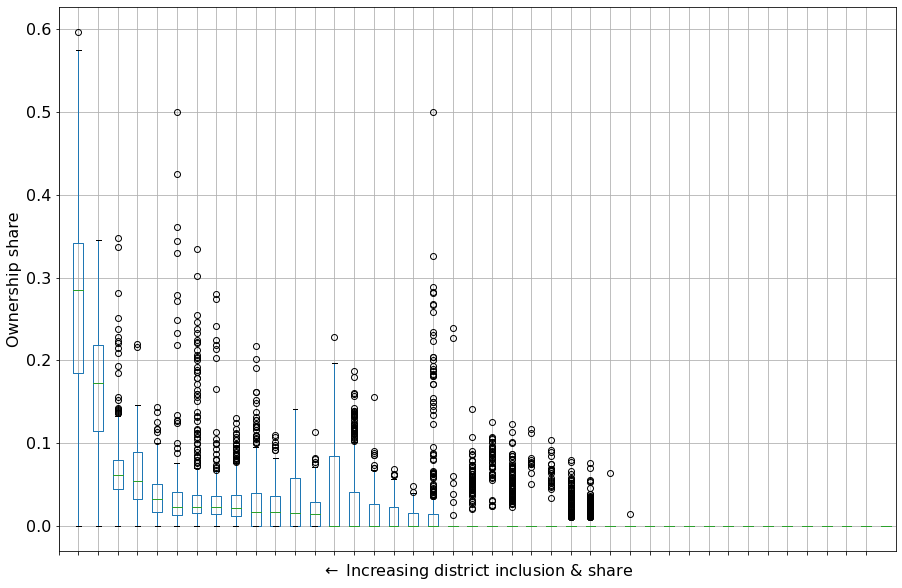

In [9]:
plt.figure(figsize=(15,10))
df_shares.boxplot()
dum = plt.xticks(rotation=90)
plt.xticks(range(df_shares.shape[1]), labels=[])
plt.xlabel(r'$\leftarrow$ Increasing district inclusion & share', fontsize=16)
plt.ylabel('Ownership share', fontsize=16)
plt.yticks(fontsize=16)

In [10]:
df_shares = shares.loc[:, shares.sum(axis=0) > 0]
df_stats = df_shares.describe()
### first sort by median
order = df_stats.loc['50%'].sort_values(ascending=False).index
df_stats = df_stats[order]
### for those with zero median, sort by 75%
num_nonzero = sum([df_stats.loc['50%', order[i]] > 0 for i in range(len(order))])
order = list(order[:num_nonzero]) + list(df_stats.loc['75%', order[num_nonzero:]].sort_values(ascending=False).index)
df_stats = df_stats[order]
### for those with zero 75%, sort by max
num_nonzero = sum([df_stats.loc['75%', order[i]] > 0 for i in range(len(order))])
order = list(order[:num_nonzero]) + list(df_stats.loc['max', order[num_nonzero:]].sort_values(ascending=False).index)
df_stats = df_stats[order]

df_shares = df_shares.loc[:, order]
df_shares.reset_index(inplace=True, drop=True)

### sort df_shares by N_P
df_shares = df_shares.iloc[objs.sort_values(['n_p', 'cwg_p'], ascending=False).index, :].reset_index(drop=True)

### patches plot, showing shares in different solutions. use custom scale
ndistricts = df_shares.shape[1] 
nsolns = df_shares.shape[0]
cmap = cm.get_cmap('YlGnBu')
oldcolors = cmap(np.linspace(0.15, 1, 6))
# cmap = cm.get_cmap('viridis_r')
# oldcolors = cmap(np.linspace(0, 1, 6))
newcolors = cmap(np.linspace(0, 1, 2560))
breaks = [int(2560 * b) for b in [0.01,0.03, 0.07, 0.15, 0.3, 1]]
newcolors[:breaks[0]] = [0.8,0.8,0.8, 1]
for i , b in enumerate(breaks[:-1]):
    newcolors[b:breaks[i+1]] = oldcolors[i]
cmap_class = ListedColormap(newcolors)
mappable = cm.ScalarMappable(cmap=cmap_class)

### separate cmap class with even intervals for colorbar
breaks_even = [int(2560 * b) for b in [1/6,2/6,3/6,4/6,5/6,1]]
newcolors_even = cmap(np.linspace(0, 1, 2560))
newcolors_even[:breaks_even[0]] = [0.8,0.8,0.8, 1]
for i , b in enumerate(breaks_even[:-1]):
    newcolors_even[b:b+10] = [0,0,0,1]
    newcolors_even[b+10:breaks_even[i+1]] = oldcolors[i]
cmap_class_even = ListedColormap(newcolors_even)

mappable_even = cm.ScalarMappable(cmap=cmap_class_even)

# fig, ax = plt.subplots(1, figsize=(16,8))
# shareboxes = []
# colors = []
# for d in range(ndistricts):
#     for s in range(nsolns):
#         share = df_shares.iloc[s, d]
#         shareboxes = [Rectangle((s, ndistricts - d - 1), 1, 1)]
#         color = cmap_class(share)
#         if share == 0.:
#             alpha = 0
#         else:
#             alpha = 1
# #         pc = PatchCollection(shareboxes, facecolor=color, edgecolor='k', alpha=alpha)
#         pc = PatchCollection(shareboxes, facecolor=color, alpha=alpha)
#         ax.add_collection(pc)
# ax.set_xlim([0,nsolns])
# ax.set_ylim([0,ndistricts])
# ax.set_xticks([])
# ax.set_xlabel(r'$\leftarrow$ Increasing size of partnership', fontsize=16)
# ax.set_ylabel(r'Increasing district inclusion & share $\rightarrow$', fontsize=16)
# # _ = ax.set_yticks(np.arange(ndistricts - 0.5, 0, -1), [s.split('_')[1] for s in df_shares.columns[:-1]], fontsize='14')
# _ = ax.set_yticks(np.arange(ndistricts - 0.5, 0, -1), labels=[], fontsize='14')
# cb = plt.colorbar(sm, ax=ax, ticks=[0.01,0.03, 0.07, 0.15, 0.3,0.6])
# _ = cb.ax.set_yticklabels([1,3,7,15,30,60], fontsize=16)
# _ = cb.set_label('ownership share (%)', fontsize=16)
# _ = cb.ax.set_ylim([0.01,0.6])


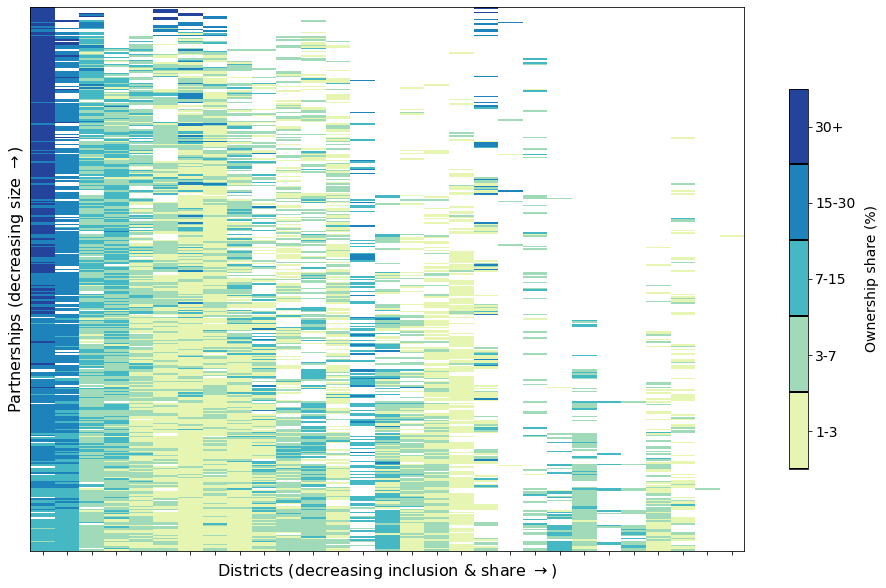

In [11]:
### quilt plot
fig_stage = 3   # 0 = none, 1 = single soln, 2 = single district, 3 = all 

fig, ax = plt.subplots(1, figsize=(16,10))
shareboxes = []
colors = []
for d in range(ndistricts):
    for s in range(nsolns):
        share = df_shares.iloc[s, d]
        color = cmap_class(share)
        if share == 0.:
            alpha = 0
        else:
            alpha = 1
        shareboxes = [Rectangle((d, s), 1, 1)]
        
        if fig_stage == 0:
            alpha = 0
        elif fig_stage == 1:
            if s != int(nsolns/2):
                alpha = 0
            shareboxes = [Rectangle((d, s-6), 1, 7)]
        elif fig_stage == 2:
            if d != int(ndistricts/2):
                alpha = 0
            
        
#         pc = PatchCollection(shareboxes, facecolor=color, edgecolor='k', alpha=alpha)
        pc = PatchCollection(shareboxes, facecolor=color, alpha=alpha)
        ax.add_collection(pc)
        
ax.set_ylim([0,nsolns])
ax.set_xlim([0,ndistricts])
ax.set_yticks([])
ax.set_ylabel(r'Partnerships (decreasing size $\rightarrow$)', fontsize=16)
ax.set_xlabel(r'Districts (decreasing inclusion & share $\rightarrow$)', fontsize=16)
# _ = ax.set_yticks(np.arange(ndistricts - 0.5, 0, -1), [s.split('_')[1] for s in df_shares.columns[:-1]], fontsize=16)
_ = ax.set_xticks(np.arange(ndistricts - 0.5, 0, -1), labels=[], fontsize=16)

cb = plt.colorbar(mappable_even, ax=ax, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.7)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

plt.savefig(f'{fig_dir}ownership_quilt_{fig_stage}.png', bbox_inches='tight', dpi=300)


In [12]:
# https://chart-studio.plotly.com/~empet/15191/texas-bivariate-choropleth-assoc/#/
jstevens = ["#e8e8e8", "#ace4e4", "#5ac8c8", "#dfb0d6", "#a5add3", 
            "#5698b9", "#be64ac", "#8c62aa", "#3b4994"]  # second example, pink/aqua

# jstevens = ["#e8e8e8", "#e4acac", "#c85a5a", "#b0d5df", "#ad9ea5", 
#             "#985356", "#64acbe", "#627f8c", "#574249"]  # first example, blue/red

# jstevens = ["#e8e8e8", "#b0d5df",  "#64acbe", "#e4acac", "#ad9ea5", 
#             "#627f8c", "#c85a5a", "#985356","#574249"]  # first example, but transpose

share_bounds = [0.05, 0.1, 1]
inclusion_bounds = [0.25, 0.75, 1]

# jstevens = ['#E8E8E8', '#C5E0E0', '#A1D8D8', '#7ED0D0', '#5AC8C8',
#             '#DEC7D9', '#BBBFD2', '#98B8CA', '#75B0C3', '#52A8BB',
#             '#D3A6CA', '#B19FC3', '#8F98BC', '#6D90B5', '#4B89AE',
#             '#C985BB', '#A87EB5', '#8677AE', '#6570A8', '#4369A1',
#             '#BE64AC', '#9D5DA6', '#7D57A0', '#5C509A', '#3B4994']
# share_bounds = [0.01, 0.03, 0.07, 0.15, 1]
# inclusion_bounds = [0.01, 0.25, 0.5, 0.75, 1]


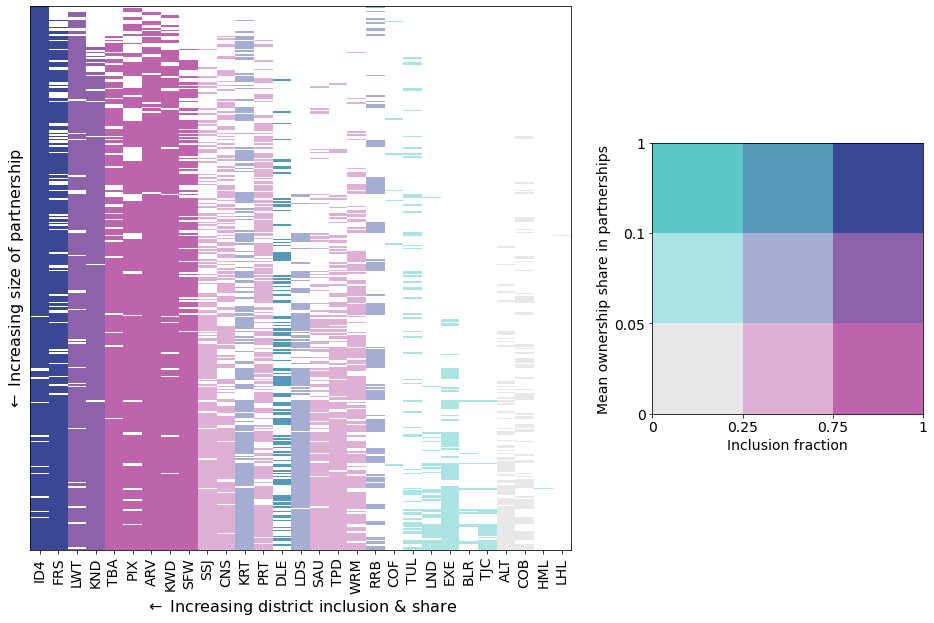

In [13]:
### test bivariate chloropleth 
fig, axs = plt.subplots(1,2, figsize=(16,10), gridspec_kw={'width_ratios': [0.66,0.33]})
ax = axs[0]

for d in range(ndistricts):
    count = 0
    stop = False
    for inclusion_bound in inclusion_bounds:
        for share_bound in share_bounds:
            if (not stop) and (np.mean(df_shares.iloc[:, d] > 0) < inclusion_bound):
                if (not stop) and (df_shares.iloc[:,d].loc[df_shares.iloc[:,d] > 0].mean() < share_bound):
                    color = jstevens[count]
                    stop = True
            count += 1

    for s in range(nsolns):
        share = df_shares.iloc[s, d]
        shareboxes = [Rectangle((d, s), 1, 1)]
        if share == 0.:
            alpha = 0
        else:
            alpha = 1
        pc = PatchCollection(shareboxes, facecolor=color, alpha=alpha)
        ax.add_collection(pc)
        
ax.set_ylim([0,nsolns])
ax.set_xlim([0,ndistricts])
ax.set_yticks([])
ax.set_ylabel(r'$\leftarrow$ Increasing size of partnership', fontsize=16)
ax.set_xlabel(r'$\leftarrow$ Increasing district inclusion & share', fontsize=16)
# _ = ax.set_xticks(np.arange(ndistricts - 0.5, 0, -1), labels=[], fontsize='14')
_ = ax.set_xticks(np.arange(0.5, ndistricts, 1), [s.split('_')[1] for s in df_shares.columns], fontsize='14', rotation=90)


ax = axs[1]
ax.set_aspect('equal', adjustable='box')
count = 0
xticks = [0]
yticks = [0]
for i,inclusion_bound in enumerate(inclusion_bounds):
    for j,share_bound in enumerate(share_bounds):
        shareboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(shareboxes, facecolor=jstevens[count], alpha=1)
        count += 1
        ax.add_collection(pc)
        if i == 0:
            yticks.append(share_bound)
    xticks.append(inclusion_bound)

        
_=ax.set_xlim([0,len(share_bounds)])
_=ax.set_ylim([0,len(inclusion_bounds)])
_=ax.set_xticks(list(range(len(share_bounds)+1)), xticks, fontsize='14')
_=ax.set_xlabel('Inclusion fraction', fontsize='14')
_=ax.set_yticks(list(range(len(share_bounds)+1)), yticks, fontsize='14')
_=ax.set_ylabel('Mean ownership share in partnerships', fontsize='14')

In [14]:
results.columns

Index(['label', 'proj', 'share_FRS', 'share_COF', 'share_TUL', 'share_KWD',
       'share_EXE', 'share_LDS', 'share_LND', 'share_PRT', 'share_LWT',
       'share_TPD', 'share_SAU', 'share_TBA', 'share_PIX', 'share_DLE',
       'share_KRT', 'share_SSJ', 'share_SFW', 'share_NKN', 'share_ARV',
       'share_DLR', 'share_ID4', 'share_SMI', 'share_TJC', 'share_BLR',
       'share_LHL', 'share_BDM', 'share_WRM', 'share_COB', 'share_BVA',
       'share_CWO', 'share_HML', 'share_KND', 'share_RRB', 'share_CNS',
       'share_ALT', 'share_CWC', 'share_MAD', 'share_SOC', 'share_SOB',
       'share_CCA', 'share_OTL', 'share_OFK', 'cwg_p', 'ap_p', 'cwg_np',
       'cog_wp_p90', 'n_p', 'cog_wp_p50', 'cog_p_p90', 'cog_p_p50'],
      dtype='object')

### Analyze district-level distributions of outcomes using full MC

In [15]:
### get list of solns to highlight
# results.loc[results['ap_p'] == results['ap_p'].max(),:]

### get satisficing condition
satisfice = np.logical_and(np.logical_and(results['cwg_np'] >= 0, results['cog_wp_p90'] <= 200), results['n_p'] >= 5)
results.loc[satisfice].loc[results.loc[satisfice]['ap_p'] == results.loc[satisfice]['ap_p'].max()] 

,label,proj,share_FRS,share_COF,share_TUL,share_KWD,share_EXE,share_LDS,share_LND,share_PRT,...,share_OTL,share_OFK,cwg_p,ap_p,cwg_np,cog_wp_p90,n_p,cog_wp_p50,cog_p_p90,cog_p_p50
252,soln599,3.0,0.0,0.0,0.0,0.028898,0.0,0.0,0.0,0.0,...,0.0,0.0,87.91418,60.760748,7.841344,129.18517,9,108.835721,75.057229,58.457132


In [16]:
### first look at cwg_p-maximizing partnership
# soln = 'soln1224'

# ### cog_wp_p90-minimizing partership
# soln = 'soln2'

### n_p-maximizing partnership
# soln = 'soln196'

### ap_p-maximizing partnership
# soln = 'soln817'

### ap_p-max within satisficing partnerships
soln = 'soln599'

results_soln = results.loc[results['label'] == soln]
results_soln

,label,proj,share_FRS,share_COF,share_TUL,share_KWD,share_EXE,share_LDS,share_LND,share_PRT,...,share_OTL,share_OFK,cwg_p,ap_p,cwg_np,cog_wp_p90,n_p,cog_wp_p50,cog_p_p90,cog_p_p50
252,soln599,3.0,0.0,0.0,0.0,0.028898,0.0,0.0,0.0,0.0,...,0.0,0.0,87.91418,60.760748,7.841344,129.18517,9,108.835721,75.057229,58.457132


In [17]:
### get partners with nonzero shares, ordered by share
sharecols = [c for c in results_soln.columns if 'share' in c]
partners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] > 0]
shares = [results_soln[f'share_{c}'].iloc[0] for c in partners]
order = np.argsort(shares)[::-1]
shares = [shares[o] for o in order]
partners = [partners[o] for o in order]
print(shares)
print(partners)

[0.3191392024468319, 0.1864105571467451, 0.1242272650691411, 0.0951494278197535, 0.0783076943015253, 0.0781074636150386, 0.0759191819701662, 0.0288983424268736, 0.0138408652039242]
['ID4', 'ARV', 'PIX', 'SSJ', 'TBA', 'LWT', 'SFW', 'KWD', 'KND']


In [20]:
import h5py

kaf_to_gl = 1.23
baseline = 'soln1294'

with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
    mc_soln = f[soln][...].transpose()
    mc_baseline = f[baseline][...].transpose()
    df_mc = pd.DataFrame(mc_soln - mc_baseline, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

## filter for cwg
df_mc = df_mc.loc[:, [f'{d}_avg_captured_water' for d in partners]] * kaf_to_gl
df_mc.columns = [f'{d}_cwg' for d in partners]
df_mc

,FRS_cwg,LND_cwg,ID4_cwg,LDS_cwg,TUL_cwg,LWT_cwg,CNS_cwg,TJC_cwg,KRT_cwg,RRB_cwg,...,TBA_cwg,COB_cwg,KND_cwg,SSJ_cwg,ALT_cwg,SFW_cwg,ARV_cwg,PRT_cwg,SAU_cwg,WRM_cwg
mc33,4.910476,3.063966,8.936354,2.439491,3.149585,5.655864,3.534453,-0.474594,3.021982,23.148842,...,2.535157,10.419911,3.273484,4.648447,0.766433,3.647529,5.921807,1.151339,1.491461,-9.180332
mc34,1.552645,2.702621,8.437474,2.251246,7.325321,3.066478,1.398852,1.013932,2.065245,8.605986,...,2.580684,6.286103,3.339584,3.296469,0.287390,2.321108,5.528272,1.792172,0.537508,6.348957
mc35,3.180278,2.087057,4.794420,1.967922,3.582252,3.689435,1.602474,0.941815,3.113662,2.652666,...,1.772534,4.979019,2.403460,2.870618,0.719163,1.970528,5.203613,1.496846,0.487575,4.597120
mc36,12.719720,3.402848,3.568397,2.788698,3.318787,2.400638,2.811456,0.970814,4.243627,1.201511,...,2.559912,1.560667,2.583294,3.035410,0.884580,1.973716,1.463627,2.431653,0.520375,4.900384
mc37,3.058489,1.272095,4.562433,1.390996,1.988884,2.481666,1.253375,0.416374,1.574928,3.471168,...,2.266209,5.195808,1.592930,1.389052,0.545747,1.345579,3.360329,1.329053,0.271467,2.114567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mc92,0.861635,2.048016,4.667665,2.199374,4.283571,5.853752,0.832348,0.847207,3.107979,2.359393,...,2.245063,6.969730,2.635740,2.538836,0.171678,1.879104,5.804473,1.256020,0.889480,5.699568
mc93,1.721157,4.361580,6.403322,2.800889,8.208948,10.652708,2.161185,0.935720,3.816877,6.126872,...,2.828921,1.048244,4.943974,4.699371,0.493576,4.066781,12.604775,1.985213,1.628330,7.060541
mc94,11.846604,2.469904,4.890689,1.994599,5.261144,4.332214,2.253511,0.625418,2.073105,2.449261,...,2.167472,6.016677,1.352898,2.920596,0.345779,2.008431,7.177130,1.681533,1.162035,4.266105
mc95,1.917399,2.596390,9.635539,2.180562,4.394400,3.682161,1.327424,0.850759,2.463709,10.690061,...,2.282842,11.976448,3.766865,2.834796,0.317544,1.801671,5.446414,1.774208,0.714368,5.348365


In [19]:
print(df_mc.mean(axis=0).sum())

87.91418023976122


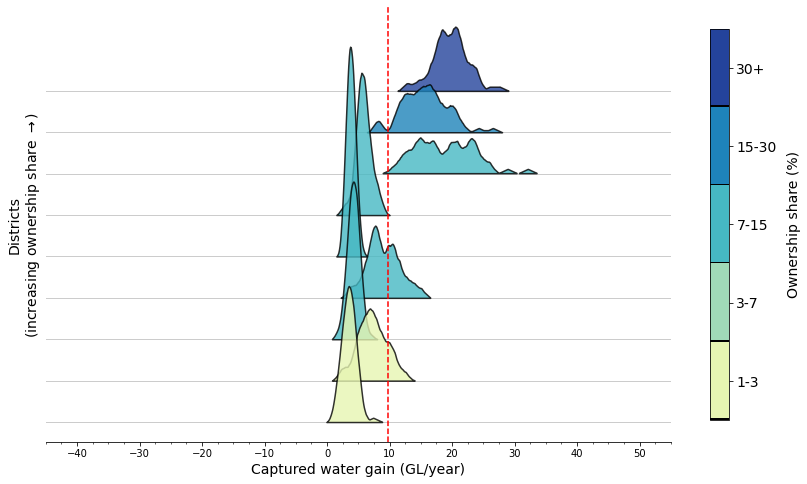

In [20]:
### ridge plot for CWG of each partner, using statsmodels triangular kde
import statsmodels.api as sm
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, ax = plt.subplots(1, figsize=(14,8))
ridgesep = 0.1
xmin = -45
xmax = 55
for i,d in enumerate(partners):
    ### set bottom of "ridge" in decreasing order (smallest share at bottom)
    bottom = (-i * ridgesep)
    plt.axhline(bottom, color='0.8', zorder=1, lw=1)

    ### evaluate & plot kde
    c = f'{d}_cwg'
    kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
    kde_district.fit(kernel='tri', fft=False, bw=1.5)
    x = np.arange(xmin, xmax, 0.1)
    y = []
    for xx in x:
        yy = kde_district.evaluate(xx)
        if np.isnan(yy):
            y.append(0.)
        else:
            y.append(yy[0])
    y = np.array(y)
    color = cmap_class(shares[i])
    plt.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

plt.axvline(results_soln['cwg_p'].iloc[0] / len(partners), color='r', ls='--')
plt.yticks([])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(2.5))

plt.xlim([xmin, xmax])
plt.ylabel('Districts\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
plt.xlabel('Captured water gain (GL/year)', fontsize=fontsize)
ax.spines[['top', 'left', 'right']].set_visible(False)


### add colorbar 
cb = plt.colorbar(mappable_even, ax=ax, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.9)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

In [21]:
#### get annual paymetns for infrastructure
FKC_participant_payment = 50e6
CFWB_cost = 50e6
interest_annual = 0.03
time_horizon = 30
cap = 1000
projects = {0: 'none', 1: 'FKC', 2: 'CFWB', 3: 'FKC_CFWB'}
principle = {'none': 0., 'FKC': FKC_participant_payment, 'CFWB': CFWB_cost, 'FKC_CFWB': FKC_participant_payment + CFWB_cost}
payments_per_yr = 1
interest_rt = interest_annual / payments_per_yr
num_payments = time_horizon * payments_per_yr
annual_debt_payment_dict = {k: principle[k] / (((1 + interest_rt) ** num_payments - 1) / (interest_rt * (1 + interest_rt) ** num_payments)) for k in principle}

project = projects[results_soln['proj'].iloc[0]]
annual_debt_payment = annual_debt_payment_dict[project]

### get cost of gains in each MC sample for each partner
partner_shares = [results_soln[f'share_{d}'].iloc[0] for d in partners]
for i,d in enumerate(partners):
    df_mc[f'{d}_cog'] = (annual_debt_payment * partner_shares[i]) / df_mc[f'{d}_cwg'] / 1000
    df_mc[f'{d}_cog'].loc[df_mc[f'{d}_cog'] > cap] = cap
    df_mc[f'{d}_cog'].loc[df_mc[f'{d}_cog'] < 0] = cap
    
df_mc

,ID4_cwg,ARV_cwg,PIX_cwg,SSJ_cwg,TBA_cwg,LWT_cwg,SFW_cwg,KWD_cwg,KND_cwg,ID4_cog,ARV_cog,PIX_cog,SSJ_cog,TBA_cog,LWT_cog,SFW_cog,KWD_cog,KND_cog
mc33,20.883312,18.642781,22.369299,6.034874,3.556206,10.509884,4.782915,8.754224,3.342608,77.967736,51.014537,28.333400,80.440017,112.344458,37.916546,80.982832,16.841835,21.125741
mc34,22.669953,17.661563,16.153434,5.531111,3.786233,8.101749,3.977896,9.679127,3.395844,71.823023,53.848737,39.236133,87.766335,105.519139,49.186726,97.371589,15.232490,20.794558
mc35,18.443944,12.795452,18.340853,6.035903,3.179601,6.598887,3.738579,7.333118,2.392632,88.279630,74.327415,34.556642,80.426301,125.651021,60.388746,103.604604,20.105662,29.513552
mc36,19.653151,12.366204,25.315092,6.681145,4.175010,7.556496,4.469833,10.849617,2.904619,82.848016,76.907424,25.036382,72.659002,95.693207,52.735885,86.655153,13.589162,24.311301
mc37,13.057874,8.217041,12.636945,2.943644,3.542723,3.904424,2.417579,2.862182,2.153268,124.692927,115.741527,50.154395,164.913071,112.772034,102.063318,160.215671,51.512171,32.794376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mc92,20.911733,15.054807,21.290310,4.803201,3.298962,8.612166,3.661014,8.671399,2.996405,77.861772,63.172705,29.769331,101.067052,121.104785,46.271578,105.799667,17.002701,23.566598
mc93,20.191793,26.534397,25.978497,8.098876,4.967384,15.038006,6.586709,12.580895,5.310371,80.637938,35.842264,24.397035,59.939844,80.428657,26.499423,58.805400,11.719134,13.297578
mc94,20.162513,15.893435,14.153608,6.206586,3.407515,8.099609,4.292425,10.322293,2.810113,80.755042,59.839353,44.779982,78.214545,117.246746,49.199719,90.236646,14.283377,25.128903
mc95,21.300279,15.401215,14.595406,5.946042,3.745972,7.482969,3.663172,5.955305,4.093043,76.441468,61.751807,43.424506,81.641762,106.653248,53.254059,105.737321,24.757288,17.252461


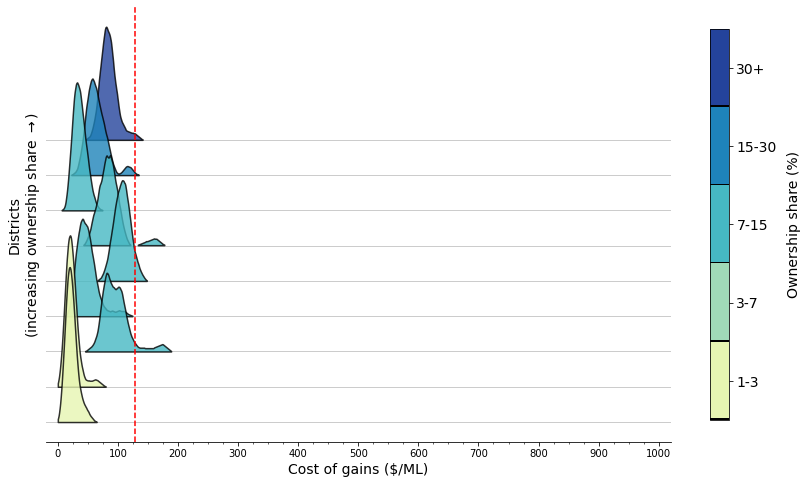

In [22]:
### ridge plot for COG of each partner, using statsmodels triangular kde
import statsmodels.api as sm

fig, ax = plt.subplots(1, figsize=(14,8))
ridgesep = 0.01
xmin = -20
xmax = 1020
for i,d in enumerate(partners):
    ### set bottom of "ridge" in decreasing order (smallest share at bottom)
    bottom = (-i * ridgesep)
    plt.axhline(bottom, color='0.8', zorder=1, lw=1)

    ### evaluate & plot kde
    c = f'{d}_cog'
    kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
    kde_district.fit(kernel='tri', fft=False, bw=15)
    x = np.arange(xmin, xmax, 0.5)
    y = []
    for xx in x:
        yy = kde_district.evaluate(xx)
        if np.isnan(yy):
            y.append(0.)
        else:
            y.append(yy[0])
    y = np.array(y)
    color = cmap_class(shares[i])
    plt.fill_between(x, y + bottom, bottom, where=np.logical_and(y > 0.0001, x >= 0), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

plt.axvline(results_soln['cog_wp_p90'].iloc[0], color='red', ls='--')
plt.yticks([])
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_minor_locator(MultipleLocator(25))

plt.xlim([xmin, xmax])
plt.ylabel('Districts\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
plt.xlabel('Cost of gains ($/ML)', fontsize=fontsize)
ax.spines[['top', 'left', 'right']].set_visible(False)

### add colorbar 
cb = plt.colorbar(mappable_even, ax=ax, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.9)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

NameError: name 'projects' is not defined

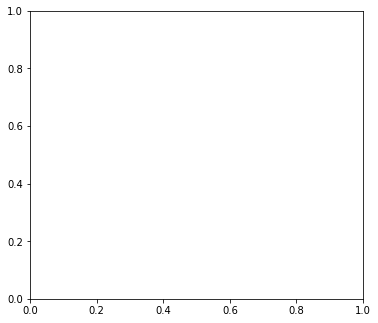

In [21]:
### 8-part figure with district-level CWG & COG MC results, 4 example partnerships
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = [['a)', 'b)'], ['c)','d)'], ['e)','f)'], ['g)','h)']]
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[20,11,4.5,9], width_ratios=[5,5,1], hspace=0.25, wspace=0.1)
for row, soln in enumerate(solns):
    ax0 = fig.add_subplot(gs[row, 0])
    results_soln = results.loc[results['label'] == soln]
    
    ### get partners with nonzero shares, ordered by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    partners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] > 0]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in partners]
    order = np.argsort(shares)[::-1]
    shares = [shares[o] for o in order]
    partners = [partners[o] for o in order]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_soln - mc_baseline, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for cwg
    cap = 1000
    df_mc = df_mc.loc[:, [f'{d}_avg_captured_water' for d in partners]] * kaf_to_gl
    df_mc.columns = [f'{d}_cwg' for d in partners]
    
    ### get cost of gains in each MC sample for each partner
    project = projects[results_soln['proj'].iloc[0]]
    annual_debt_payment = annual_debt_payment_dict[project]
    partner_shares = [results_soln[f'share_{d}'].iloc[0] for d in partners]
    for i,d in enumerate(partners):
        df_mc[f'{d}_cog'] = (annual_debt_payment * partner_shares[i]) / df_mc[f'{d}_cwg'] / 1000
        df_mc[f'{d}_cog'].loc[df_mc[f'{d}_cog'] > cap] = cap
        df_mc[f'{d}_cog'].loc[df_mc[f'{d}_cog'] < 0] = cap
    
    ridgesep = 0.1
    xmin = -45
    xmax = 55
    for i,d in enumerate(partners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_cwg'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['cwg_p'].iloc[0] / len(partners), color='r', ls='--')
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Captured water gain (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)

    
    ### now do cost of gains figures
    ax1 = fig.add_subplot(gs[row, 1])
    ridgesep = 0.01
    xmin = -20
    xmax = 1020
    for i,d in enumerate(partners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax1.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_cog'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=15)
        x = np.arange(xmin, xmax, 0.5)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax1.fill_between(x, y + bottom, bottom, where=np.logical_and(y > 0.0001, x >= 0), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax1.axvline(min(results_soln['cog_wp_p90'].iloc[0], cap), color='red', ls='--')
    ax1.set_yticks([])
    ax1.xaxis.set_major_locator(MultipleLocator(100))
    ax1.xaxis.set_minor_locator(MultipleLocator(25))

    ax1.set_xlim([xmin, xmax])
#     ax1.set_ylabel('Districts\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax1.set_xlabel('Cost of gains ($/ML)', fontsize=fontsize)
    ax1.spines[['top', 'left', 'right']].set_visible(False)

    ### adjust ylims so that right and left match
    ylim0 = ax0.get_ylim()
    ylim1 = ax1.get_ylim()
    ylim0_new = [min(ylim0[0], ylim1[0]*10), max(ylim0[1], ylim1[1]*10)]
    ylim1_new = [y/10 for y in ylim0_new]
    ax0.set_ylim(ylim0_new)
    ax1.set_ylim(ylim1_new)
    
    ### label subfigs
    ax0.annotate(labels[row][0], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)
    ax1.annotate(labels[row][1], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

### add colorbar 
ax2 = fig.add_subplot(gs[0,2])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
cb = plt.colorbar(mappable_even, ax=ax2, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.9, fraction=1)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

plt.savefig(f'{fig_dir}partners_cwg_cog_pdfs.png', bbox_inches='tight', dpi=300)


NameError: name 'projects' is not defined

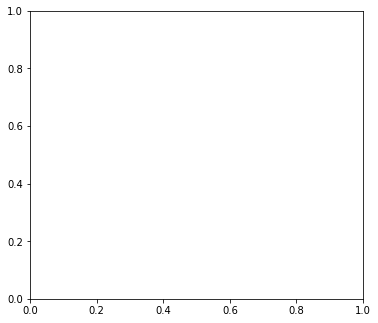

In [22]:
### 8-part figure with district-level pumping reduction (PR) & cost of reduction (CR) MC results, 4 example partnerships
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = [['a)', 'b)'], ['c)','d)'], ['e)','f)'], ['g)','h)']]
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[20,11,4.5,9], width_ratios=[5,5,1], hspace=0.25, wspace=0.1)
for row, soln in enumerate(solns):
    ax0 = fig.add_subplot(gs[row, 0])
    results_soln = results.loc[results['label'] == soln]
    
    ### get partners with nonzero shares, ordered by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    partners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] > 0]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in partners]
    order = np.argsort(shares)[::-1]
    shares = [shares[o] for o in order]
    partners = [partners[o] for o in order]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_baseline - mc_soln, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for pr
    cap = 1000
    df_mc = df_mc.loc[:, [f'{d}_avg_pumping' for d in partners]] * kaf_to_gl
    df_mc.columns = [f'{d}_pr' for d in partners]
    
    ### get cost of reductions in each MC sample for each partner
    project = projects[results_soln['proj'].iloc[0]]
    annual_debt_payment = annual_debt_payment_dict[project]
    partner_shares = [results_soln[f'share_{d}'].iloc[0] for d in partners]
    for i,d in enumerate(partners):
        df_mc[f'{d}_cor'] = (annual_debt_payment * partner_shares[i]) / df_mc[f'{d}_pr'] / 1000
        df_mc[f'{d}_cor'].loc[df_mc[f'{d}_cor'] > cap] = cap
        df_mc[f'{d}_cor'].loc[df_mc[f'{d}_cor'] < 0] = cap
    
    ridgesep = 0.1
    xmin = -10
    xmax = 50
    for i,d in enumerate(partners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_pr'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['ap_p'].iloc[0] / len(partners), color='r', ls='--')
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Pumping reduction (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)

    
    ### now do cost of reductions figures
    ax1 = fig.add_subplot(gs[row, 1])
    ridgesep = 0.01
    xmin = -20
    xmax = 1020
    for i,d in enumerate(partners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax1.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_cor'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=15)
        x = np.arange(xmin, xmax, 0.5)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax1.fill_between(x, y + bottom, bottom, where=np.logical_and(y > 0.0001, x >= 0), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

#     ax1.axvline(min(results_soln['cog_wp_p90'].iloc[0], cap), color='red', ls='--')
    ax1.set_yticks([])
    ax1.xaxis.set_major_locator(MultipleLocator(100))
    ax1.xaxis.set_minor_locator(MultipleLocator(25))

    ax1.set_xlim([xmin, xmax])
#     ax1.set_ylabel('Districts\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax1.set_xlabel('Cost of reduction ($/ML)', fontsize=fontsize)
    ax1.spines[['top', 'left', 'right']].set_visible(False)

    ### adjust ylims so that right and left match
    ylim0 = ax0.get_ylim()
    ylim1 = ax1.get_ylim()
    ylim0_new = [min(ylim0[0], ylim1[0]*10), max(ylim0[1], ylim1[1]*10)]
    ylim1_new = [y/10 for y in ylim0_new]
    ax0.set_ylim(ylim0_new)
    ax1.set_ylim(ylim1_new)
    
    ### label subfigs
    ax0.annotate(labels[row][0], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)
    ax1.annotate(labels[row][1], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

### add colorbar 
ax2 = fig.add_subplot(gs[0,2])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
cb = plt.colorbar(mappable_even, ax=ax2, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.9, fraction=1)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

# plt.savefig(f'{fig_dir}partners_pr_cor_pdfs.png', bbox_inches='tight', dpi=300)


KND -14.670833693399715
OFK -25.976150840256413
OFK -14.34381984388425
OFK 10.425045875502413


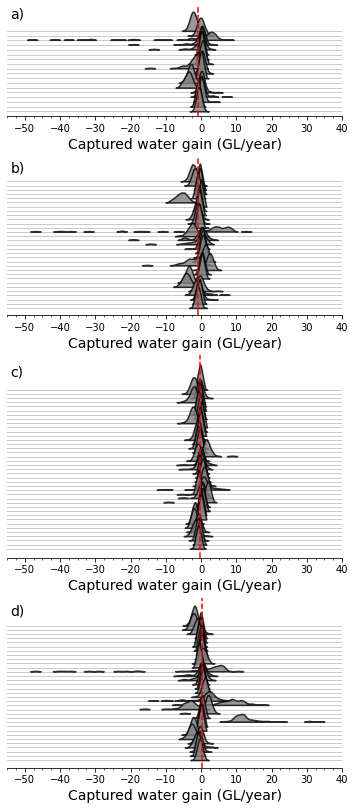

In [25]:
### repeat district-level CWG results for non-partners
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = ['a)', 'b)', 'c)', 'd)']
fig = plt.figure(figsize=(6,14))
gs = gridspec.GridSpec(nrows=4, ncols=1, height_ratios=[40-20,40-11,40-3,40-9], width_ratios=[1], hspace=0.25, wspace=0.1)
for row, soln in enumerate(solns):
    ax0 = fig.add_subplot(gs[row, 0])
    results_soln = results.loc[results['label'] == soln]
    
    ### get nonpartners with zero shares
    sharecols = [c for c in results_soln.columns if 'share' in c]
    nonpartners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] == 0]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_soln - mc_baseline, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for cwg
    df_mc = df_mc.loc[:, [f'{d}_avg_captured_water' for d in nonpartners]] * kaf_to_gl
    df_mc.columns = [f'{d}_cwg' for d in nonpartners]
    print(d, df_mc.sum(axis=1).mean())
    
    ### ridgeplot
    ridgesep = 0.1
    xmin = -55
    xmax = 40
    for i,d in enumerate(nonpartners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_cwg'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = '0.5'
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['cwg_np'].iloc[0] / len(nonpartners), color='r', ls='--')
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Captured water gain (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)
    
    ### label subfigs
    ax0.annotate(labels[row], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

plt.savefig(f'{fig_dir}nonpartners_cwg_pdfs.png', bbox_inches='tight', dpi=300)


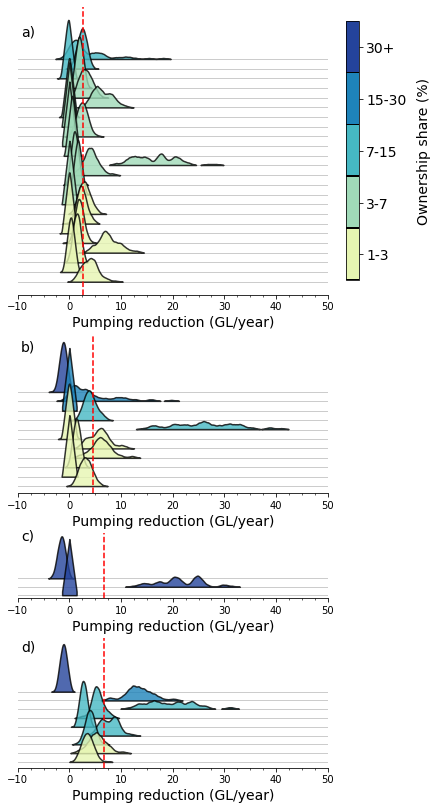

In [26]:
### 4-part figure with district-level AP MC results, 4 example partnerships
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = ['a)', 'b)', 'c)','d)']
fig = plt.figure(figsize=(7,14))
gs = gridspec.GridSpec(nrows=4, ncols=2, height_ratios=[20,11,4.5,9], width_ratios=[5,1], hspace=0.25, wspace=0.1)
for row, soln in enumerate(solns):
    ax0 = fig.add_subplot(gs[row, 0])
    results_soln = results.loc[results['label'] == soln]
    
    ### get partners with nonzero shares, ordered by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    partners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] > 0]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in partners]
    order = np.argsort(shares)[::-1]
    shares = [shares[o] for o in order]
    partners = [partners[o] for o in order]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_baseline - mc_soln, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for cwg
    df_mc = df_mc.loc[:, [f'{d}_avg_pumping' for d in partners]] * kaf_to_gl
    df_mc.columns = [f'{d}_ap' for d in partners]
    
    ridgesep = 0.1
    xmin = -10
    xmax = 50
    for i,d in enumerate(partners):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_ap'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['ap_p'].iloc[0] / len(partners), color='r', ls='--')
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Pumping reduction (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)

    
    ### label subfigs
    ax0.annotate(labels[row], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

### add colorbar 
ax2 = fig.add_subplot(gs[0,1])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
cb = plt.colorbar(mappable_even, ax=ax2, ticks=[3/12,5/12,7/12,9/12,11/12], shrink=0.9, fraction=1)
_ = cb.ax.set_yticklabels(['1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)
_ = cb.ax.set_ylim([2/12,1])

plt.savefig(f'{fig_dir}partners_ap_pdfs.png', bbox_inches='tight', dpi=300)


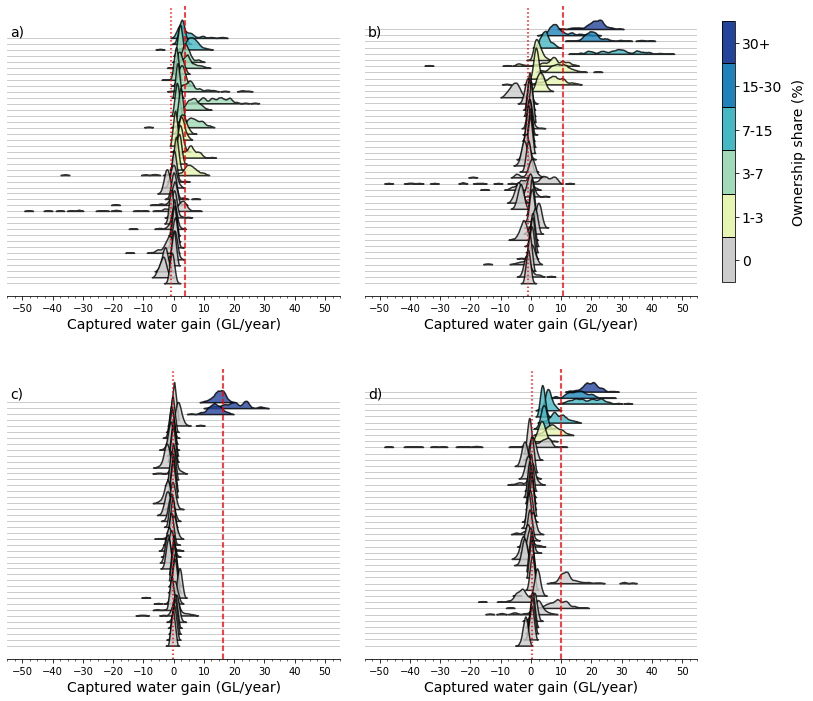

In [27]:
### 4-part figure with district-level AP MC results, for both partners & non-partnes, 4 example partnerships
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = ['a)', 'b)', 'c)','d)']
fig = plt.figure(figsize=(14,12))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1,1,], width_ratios=[5,5,1], hspace=0.25, wspace=0.1)
for count, soln in enumerate(solns):
    row = int(count/2)
    col = count % 2
    ax0 = fig.add_subplot(gs[row, col])
    results_soln = results.loc[results['label'] == soln]
    
    ### order all districts (partners + non-partners) by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    partners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] > 0]
    districts = [c.split('_')[1] for c in sharecols]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in districts]
    order = np.argsort(shares)[::-1]
    shares = [shares[o] for o in order]
    districts = [districts[o] for o in order]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_soln - mc_baseline, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for cwg
    df_mc = df_mc.loc[:, [f'{d}_avg_captured_water' for d in districts]] * kaf_to_gl
    df_mc.columns = [f'{d}_cwg' for d in districts]
    
    ridgesep = 0.1
    xmin = -55
    xmax = 55
    for i,d in enumerate(districts):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_cwg'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['cwg_p'].iloc[0] / len(partners), color='r', ls='--')
    ax0.axvline((df_mc.sum(axis=1).mean() - results_soln['cwg_p'].iloc[0]) / (len(districts) - len(partners)), color='r', ls=':')
    
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Captured water gain (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)

    
    ### label subfigs
    ax0.annotate(labels[count], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

### add colorbar 
ax2 = fig.add_subplot(gs[0,2])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
cb = plt.colorbar(mappable_even, ax=ax2, ticks=[1/12,3/12,5/12,7/12,9/12,11/12], shrink=0.9, fraction=1)
_ = cb.ax.set_yticklabels(['0', '1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)

plt.savefig(f'{fig_dir}alldistricts_cwg_pdfs.png', bbox_inches='tight', dpi=300)


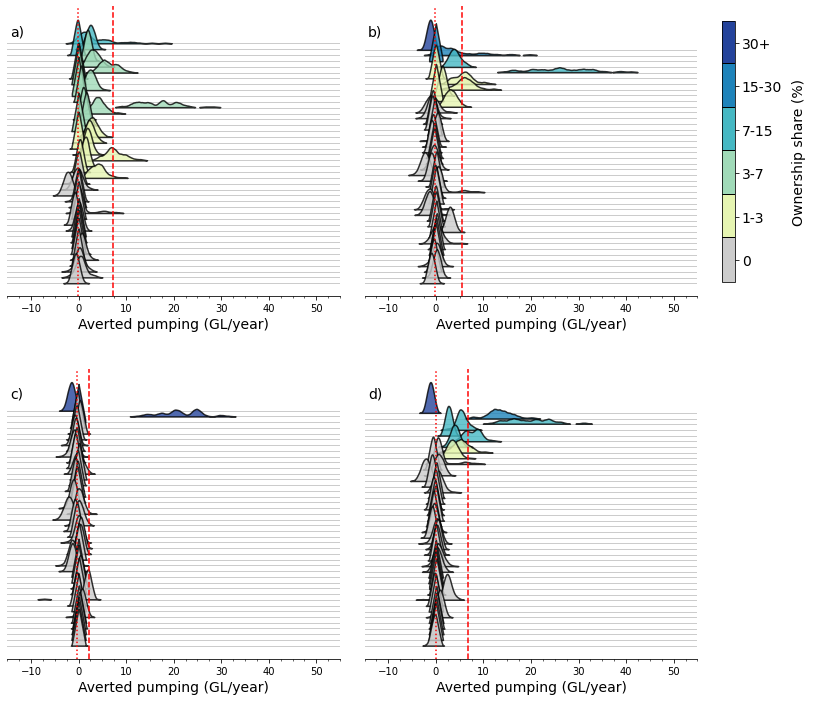

In [28]:
### 4-part figure with district-level AP MC results, for both partners & non-partnes, 4 example partnerships
import matplotlib.gridspec as gridspec

solns = ['soln196', 'soln1224', 'soln2', 'soln599']
labels = ['a)', 'b)', 'c)','d)']
fig = plt.figure(figsize=(14,12))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1,1,], width_ratios=[5,5,1], hspace=0.25, wspace=0.1)
for count, soln in enumerate(solns):
    row = int(count/2)
    col = count % 2
    ax0 = fig.add_subplot(gs[row, col])
    results_soln = results.loc[results['label'] == soln]
    
    ### order all districts (partners + non-partners) by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    districts = [c.split('_')[1] for c in sharecols]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in districts]
    order = np.argsort(shares)[::-1]
    shares = [shares[o] for o in order]
    districts = [districts[o] for o in order]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_baseline - mc_soln, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for cwg
    df_mc = df_mc.loc[:, [f'{d}_avg_pumping' for d in districts]] * kaf_to_gl
    df_mc.columns = [f'{d}_ap' for d in districts]
    
    ridgesep = 0.1
    xmin = -15
    xmax = 55
    for i,d in enumerate(districts):
        ### set bottom of "ridge" in decreasing order (smallest share at bottom)
        bottom = (-i * ridgesep)
        ax0.axhline(bottom, color='0.8', zorder=1, lw=1)

        ### evaluate & plot kde
        c = f'{d}_ap'
        kde_district = sm.nonparametric.KDEUnivariate(df_mc[c])
        kde_district.fit(kernel='tri', fft=False, bw=1.5)
        x = np.arange(xmin, xmax, 0.1)
        y = []
        for xx in x:
            yy = kde_district.evaluate(xx)
            if np.isnan(yy):
                y.append(0.)
            else:
                y.append(yy[0])
        y = np.array(y)
        color = cmap_class(shares[i])
        ax0.fill_between(x, y + bottom, bottom, where=(y > 0.00005), lw=1.5, alpha=0.8, zorder=2, fc = color, ec = 'k')

    ax0.axvline(results_soln['ap_p'].iloc[0] / len(partners), color='r', ls='--')
    ax0.axvline((df_mc.sum(axis=1).mean() - results_soln['ap_p'].iloc[0]) / (len(districts) - len(partners)), color='r', ls=':')
        
    ax0.set_yticks([])
    ax0.xaxis.set_major_locator(MultipleLocator(10))
    ax0.xaxis.set_minor_locator(MultipleLocator(2.5))

    ax0.set_xlim([xmin, xmax])
#     ax0.set_ylabel('Districts')#\n' + r'(increasing ownership share $\rightarrow$)', fontsize=fontsize)
#     if row == 3:
    ax0.set_xlabel('Averted pumping (GL/year)', fontsize=fontsize)
    ax0.spines[['top', 'left', 'right']].set_visible(False)

    
    ### label subfigs
    ax0.annotate(labels[count], xy=(0.01,0.9), xycoords='axes fraction', fontsize=fontsize)

### add colorbar 
ax2 = fig.add_subplot(gs[0,2])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
cb = plt.colorbar(mappable_even, ax=ax2, ticks=[1/12,3/12,5/12,7/12,9/12,11/12], shrink=0.9, fraction=1)
_ = cb.ax.set_yticklabels(['0', '1-3', '3-7','7-15','15-30','30+',], fontsize=fontsize)
_ = cb.set_label('Ownership share (%)', fontsize=fontsize, labelpad=10)

plt.savefig(f'{fig_dir}alldistricts_ap_pdfs.png', bbox_inches='tight', dpi=300)


### Maps

In [13]:
import geopandas as gpd
import contextily as cx
from generativepy.color import Color
from PIL import ImageColor
from matplotlib.colors import rgb2hex


#local data folder name
project_folder = 'maps/ca_geo'
projection_string = 'EPSG:4326'#project raster to data projection
projection_num = 4326
point_location_filename = project_folder + '/CALFEWS_RESERVOIRS.csv'#coordinates of map 'points'
shapefile_folder = project_folder + '/CALFEWS_Shapes/'
districts_folder = project_folder + '/CALFEWS_shapes/Water_Districts/'
canal_folder = project_folder + '/CALFEWS_shapes/Canals_and_Aqueducts_local/'
raster_folder = project_folder + '/ca_satellite/'
outline_name = project_folder + '/CALFEWS_shapes/states.shp'#state outline
id4_name = project_folder + '/ZOB7_ID4_WGS1984/ZOB7_WGS1984.shp'

In [14]:
ag_keys = {
           'BDM': ['berrendamesawaterdistrict'], 'BLR': ['belridgewaterstoragedistrict'], 'BVA': ['buenavistawaterstoragedistrict'], 
           'CWO': ['cawelowaterdistrict'], 'HML': ['henrymillerwaterdistrict'], 'KND': ['kerndeltawaterdistrict'], 'LHL': ['losthillswaterdistrict'],
           'RRB': ['rosedale-riobravowaterstoragedistrict'], 'SMI': ['semitropicwaterservicedistrict'], 'THC': ['tehachapi-cummingscountywaterdistrict'], 
           'TJC': ['tejon-castacwaterdistrict'], 'WKN': ['westkernwaterdistrict'], 'WRM': ['wheelerridge-maricopawaterstoragedistrict'],
           'COB': ['bakersfieldcityof'], 'NKN': ['northkernwaterstoragedistrict'], 'ARV': ['arvin-edisonwaterstoragedistrict'],
           'PIX': ['pixleyirrigationdistrict'], 'DLE': ['delano-earlimartirrigationdistrict'], 'EXE': ['exeterirrigationdistrict'],
           'KRT': ['kern-tulare'], 'LND': ['lindmore'], 'LDS': ['lindsay-strathmoreirrigationdistric'],
           'LWT': ['lowertule'], 'PRT': ['portervilleirrigationdistrict'], 'SAU': ['saucelito'], 'SFW': ['shafter-wascoirrigationdistrict'],
           'SSJ': ['southernsanjoaquinmunicipalutilitydistrict'], 'TPD': ['teapot'], 'TBA': ['terrabellairrigationdistrict'], 'TUL': ['tulareirrigationdistrict'],
           'COF': ['fresnocityof'], 'FRS': ['fresnoirrigation'], 
           'DLR': ['dudleyridge'], 'TLB': ['tularelake'], 'KWD': ['kaweahdelta'], 'WSL': ['westlands'], 'SNL': ['sanluiswater'], 
           'PNC': ['panoche'], 'DLP': ['delpuerto'], 'CWC': ['chowchillawaterdistrict'], 'MAD': ['maderairrigationdistrict'], 
           'CNS': ['consolidated'], 'ALT': ['altairrigationdistrict'],  
           'KWB': ['kernwaterbank'],
         
          # 'OFK': ['hillsvalley', 'orangecoveirrigationdistrict','lewiscreek','lindsaycityof','stonecorral' ,
           #        'ivanhoeirrigationdistrict', 'orangecovecityof', 'tri-valleywaterdistrict', 'internationalwaterdistrict', 
            #       'garfield', 'hiddenlakes', 'fresnocountywaterworksdistrictno18'], #'gravely'
           'KRWA': ['kingsriverwaterdistrict'],#, 'kingsriverconservationdistrict'],
           #'OEX': ['sanluiscanalcompany', 'centralcalifornia', 'firebaughcanalcompany', 'columbiacanalcompany'],
           #'OCD': ['bantacarbonairrigationdistrict, byronbethanyirrigationdistrict', 'eaglefield', 'mercysprings',
            #       'oralomawaterdistrict', 'pajarovalleywatermanagementagency', 'pattersonwaterdistrict', 'westsidewaterdistrict',
             #      'weststanislaus', 'coelho','fresnoslough', 'jamesirrigationdistrict', 'lagunawaterdistrict',
              #     '1606', 'tranquilityirrigationdistrict', 'avenal', 'coalingacityof', 'huroncityof', 'pacheco', 
               #    'tranquilitypublicutilitydistrict']#, 'tracycityof'
          }

#                   'OXV': ['hillsvalley', 'tri-valleywaterdistrict']
#,                  'KCWA': 'kerncountywateragency', }
#                   'ID4': '4', 
#                   'OKW': 'otherkaweah',
            #       'OTL': 'othertule', 
#                  'OSW': 'otherswp', 

#                  'SOC': 'socal', 'SOB': 'southbay', 'CCA': 'centralcoast', 
          

In [15]:
districts_MOO = ["FRS","COF","TUL","KWD","EXE","LDS", "LND","PRT","LWT","TPD","SAU","TBA","PIX","DLE","KRT","SSJ", 
                 "SFW","NKN","ARV", "DLR","SMI","TJC","BLR","LHL","BDM","WRM","COB","BVA","CWO","HML",
                        "KND","RRB","CNS","ALT","CWC","MAD"] #"ID4","SOC","SOB","CCA"
ag_keys = {k: ag_keys[k] for k in districts_MOO}

In [16]:
def district_match(shp_names, name):
    shp_names_lc = [k.lower().strip().replace(' ','') for k in shp_names]
    is_match = [name in k for k in shp_names_lc]
    return [i for i in range(len(is_match)) if is_match[i]], [shp_names_lc[i] for i in range(len(is_match)) if is_match[i]]

### read in shapefile of all water districts
ags = gpd.read_file(districts_folder + 'Water_Districts.shp')
ags.sort_values('AGENCYNAME', inplace=True)

### filter to only keep districts in study area
idxs = []
names = []
keys = []
for k,vs in ag_keys.items():
    for v in vs:
        idx, name = district_match(ags.AGENCYNAME, v)
        idxs += idx
        names += name
        for i in range(len(idx)):
            keys.append(k)
            
ags = ags.iloc[idxs,:]
ags.reset_index(drop=True, inplace=True)
ags['area'] = ags.geometry.area
ags['district'] = keys
ags

,OBJECTID,AGENCYNAME,SOURCE,AGENCYUNIQ,LASTMODIFI,MODIFIEDBY,SOURCECOMM,Date_Data_,GlobalID,geometry,area,district
0,32,Fresno Irrigation District,SCRO,961.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{0EA9AE2A-51F2-4E0B-B3AA-E84D50D0DD42},"MULTIPOLYGON (((-119.73811 36.88710, -119.7379...",0.101195,FRS
1,180,Fresno City Of Service area,SCRO,934.0,2016-05-23T14:09:59.000Z,SERYSIAN,None,2013-11-07T00:00:00.000Z,{AA6B6103-329A-4605-A308-E734192C2597},"POLYGON ((-119.78829 36.89553, -119.78828 36.8...",0.036911,COF
2,66,Tulare Irrigation District,SCRO,2518.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{21D33668-AA85-4E44-BBE6-A1F051A1003A},"MULTIPOLYGON (((-119.37348 36.27932, -119.3715...",0.027513,TUL
3,298,Kaweah Delta Water Conservation District,USBR-Federal,1278.0,2010-08-31T00:00:00.000Z,source,None,2010-08-31T00:00:00.000Z,{D6F406C5-16E7-433B-9287-1031BFF9232E},"POLYGON ((-119.21565 36.39227, -119.21570 36.3...",0.138077,KWD
4,76,Exeter Irrigation District,SCRO,864.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{2F22D595-2D84-4D01-849A-FFCA293922D8},"POLYGON ((-119.06237 36.36879, -119.06256 36.3...",0.006080,EXE
5,75,Lindsay - Strathmore Irrigation District,SCRO,1433.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{2684C64C-8EAA-46A5-851A-4C561C4A3EC2},"MULTIPOLYGON (((-119.08388 36.20368, -119.0824...",0.006526,LDS
6,77,Lindmore Irrigation District,SCRO,1431.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{D15D4F24-D4D2-4136-8F8E-B6DF68186085},"MULTIPOLYGON (((-119.11845 36.24257, -119.1184...",0.011066,LND
7,78,Porterville Irrigation District,SCRO,1958.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{40209707-9397-432C-B79D-67B8A8CD2502},"POLYGON ((-119.04665 36.03682, -119.04891 36.0...",0.006933,PRT
8,70,Lower Tule River Irrigation District,SCRO,1500.0,2017-01-10T10:03:55.000Z,SERYSIAN,None,2013-11-07T00:00:00.000Z,{C13BDBF9-E8BB-4C8C-9DD5-6D99198A939D},"POLYGON ((-119.14291 36.11640, -119.14296 36.1...",0.041511,LWT
9,79,Tea Pot Dome Water District,SCRO,2450.0,2013-11-07T00:00:00.000Z,source,None,2013-11-07T00:00:00.000Z,{A864C43D-79F2-4462-A1D0-FEAE51E08155},"MULTIPOLYGON (((-119.02229 36.00415, -119.0222...",0.001405,TPD


In [17]:
### get id4 and add to ags
id4 = gpd.read_file(id4_name)
id4 = id4.to_crs(ags.crs)
id4['district'] = 'ID4'

ags = ags.append(id4)

<AxesSubplot:>

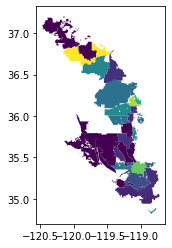

In [25]:
ags.plot('share')

ConnectionError: HTTPSConnectionPool(host='stamen-tiles-a.a.ssl.fastly.net', port=443): Max retries exceeded with url: /toner-lite/9/84/198.png (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7ff009339d30>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

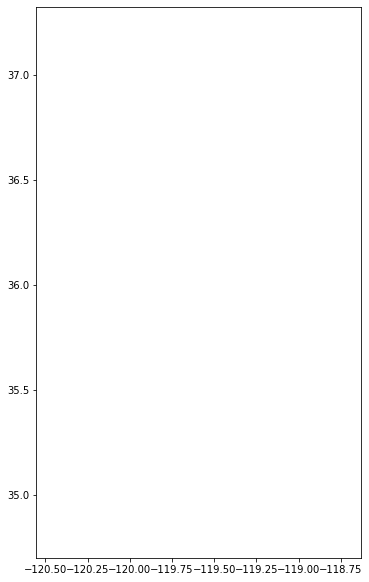

In [23]:
### share-colored maps for 4 example partnerships
fig = plt.figure(figsize=(25,25))
gs = gridspec.GridSpec(nrows=1, ncols=4, wspace=0.1)
for count, soln in enumerate(solns):
    ax0 = fig.add_subplot(gs[count])
    results_soln = results.loc[results['label'] == soln]
    
    ### order all districts (partners + non-partners) by share
    sharecols = [c for c in results_soln.columns if 'share' in c]
    districts = [c.split('_')[1] for c in sharecols]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in districts]
    share_dict = {k: v for k,v in zip(districts, shares)}
    
    ### get shares for districts in gpd
    def get_share(d):
        try:
            share = share_dict[d]
        except:
            share = 0
        return share
            
    ags['share'] = [get_share(d) for d in ags['district']]
    ags['color_share'] = [cmap_class(s) for s in ags['share']]

    ### first, plot districts with zero participation except COF&TUL, with no color but outlined in black
    condition = np.logical_and(ags['share'] == 0, [d not in ('COF', 'TUL') for d in ags['district']])
    ags.loc[condition, :].plot('share', ax=ax0, color='0.9', edgecolor='k', alpha=alpha)
    ### now plot districts with non-zero participation, except COF & TUL
    condition = np.logical_and(ags['share'] > 0, [d not in ('COF', 'TUL') for d in ags['district']])
    ags.loc[condition, :].plot('share', ax=ax0, color=ags.loc[condition, 'color_share'], edgecolor='k', alpha=alpha)
    ### lastly plot COF & TUL, which are overlapping and need to be on top
    condition = [d in ('COF', 'TUL') for d in ags['district']]
    ags.loc[condition, :].plot('share', ax=ax0, color=ags.loc[condition, 'color_share'], edgecolor='k', alpha=alpha)


    ### basemap
    cx.add_basemap(ax = ax0, crs=ags.crs, source=cx.providers.Stamen.TonerLite)

    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title(label_dict[soln])
    
plt.savefig(f'{fig_dir}exPartnership_shares.jpg', bbox_inches='tight', dpi=300)


In [35]:
df_shares

,share_ID4,share_FRS,share_LWT,share_KND,share_TBA,share_PIX,share_ARV,share_KWD,share_SFW,share_SSJ,...,share_COF,share_TUL,share_LND,share_EXE,share_BLR,share_TJC,share_ALT,share_COB,share_HML,share_LHL
0,0.083619,0.109209,0.051826,0.026023,0.033925,0.041616,0.014314,0.041223,0.014396,0.016043,...,0.0,0.054860,0.095481,0.035808,0.000000,0.046729,0.015352,0.030622,0.0,0.0
1,0.084221,0.093655,0.000000,0.086739,0.044946,0.040504,0.012945,0.053000,0.014281,0.036405,...,0.0,0.052650,0.093136,0.028131,0.000000,0.052911,0.023829,0.025096,0.0,0.0
2,0.092582,0.087886,0.046857,0.045396,0.029000,0.021393,0.010989,0.022596,0.014186,0.050771,...,0.0,0.000000,0.090507,0.022553,0.000000,0.090028,0.020654,0.025397,0.0,0.0
3,0.119734,0.099780,0.046743,0.029522,0.014456,0.016398,0.015621,0.011601,0.010378,0.018466,...,0.0,0.000000,0.071935,0.039095,0.000000,0.103793,0.014308,0.032787,0.0,0.0
4,0.096643,0.097227,0.044773,0.023553,0.015655,0.035211,0.012591,0.042013,0.013403,0.017110,...,0.0,0.043058,0.089821,0.031831,0.076893,0.068689,0.021709,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0.327530,0.000000,0.337534,0.000000,0.000000,0.000000,0.334936,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
370,0.344884,0.000000,0.000000,0.000000,0.000000,0.329217,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
371,0.575129,0.000000,0.000000,0.000000,0.000000,0.424871,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
372,0.500277,0.000000,0.000000,0.000000,0.000000,0.499723,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


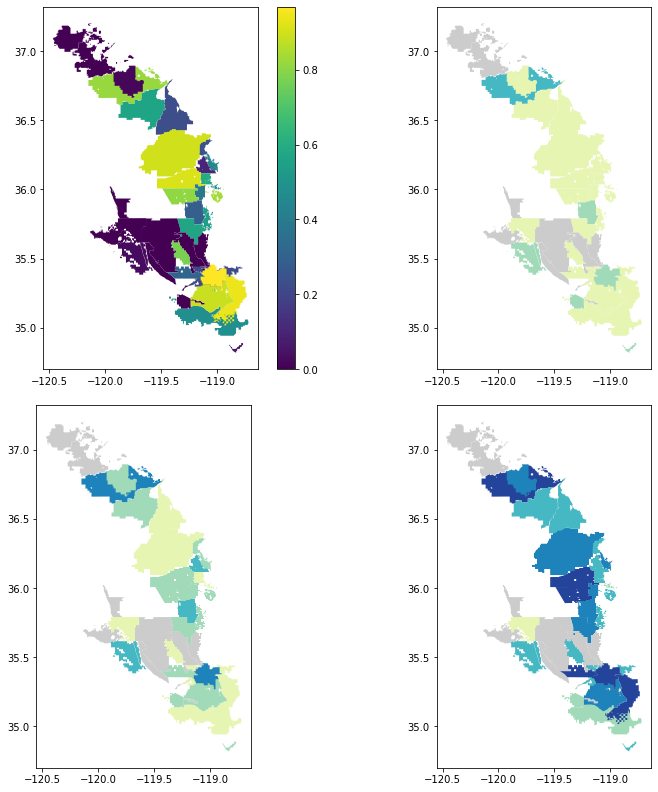

In [66]:
### maps showing the fraction of time each district is a partner, and its min/median/max share across all pareto partnerships 
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1,1], width_ratios=[1,1], hspace=0.1, wspace=0.05)

### plot fraction inclusion for each district
ax = fig.add_subplot(gs[0, 0])
def get_inclusion_frac(d):
    try:
        frac = np.mean(df_shares['share_'+d] > 0)
    except:
        frac = 0
    return frac

ags['inclusion_frac'] = [get_inclusion_frac(d) for d in ags['district']]
ags.plot('inclusion_frac', ax=ax, legend=True)
ags.head()

### plot min share when included
ax = fig.add_subplot(gs[0, 1])
def get_min_share(d):
    try:
        share = np.min(df_shares['share_'+d].loc[df_shares['share_'+d] > 0])
    except:
        share = 0
    return share

ags['min_share'] = [get_min_share(d) for d in ags['district']]
ags['color_min_share'] = [cmap_class(s) for s in ags['min_share']]
ags.plot('min_share', ax=ax, color=ags['color_min_share'], legend=True)
ags.head()

### plot median share when included
ax = fig.add_subplot(gs[1, 0])
def get_median_share(d):
    try:
        share = np.median(df_shares['share_'+d].loc[df_shares['share_'+d] > 0])
    except:
        share = 0
    return share

ags['median_share'] = [get_median_share(d) for d in ags['district']]
ags['color_median_share'] = [cmap_class(s) for s in ags['median_share']]
ags.plot('median_share', ax=ax, color=ags['color_median_share'], legend=True)
ags.head()

### plot max share when included
ax = fig.add_subplot(gs[1, 1])
def get_max_share(d):
    try:
        share = np.max(df_shares['share_'+d].loc[df_shares['share_'+d] > 0])
    except:
        share = 0
    return share

ags['max_share'] = [get_max_share(d) for d in ags['district']]
ags['color_max_share'] = [cmap_class(s) for s in ags['max_share']]
ags.plot('max_share', ax=ax, color=ags['color_max_share'], legend=True)
ags.head()

plt.savefig(f'{fig_dir}district_share_distributions.png', bbox_inches='tight', dpi=300)


In [37]:
# # https://chart-studio.plotly.com/~empet/15191/texas-bivariate-choropleth-assoc/#/
# jstevens = ["#e8e8e8", "#ace4e4", "#5ac8c8", "#dfb0d6", "#a5add3", 
#             "#5698b9", "#be64ac", "#8c62aa", "#3b4994"]  # second example, pink/aqua

# # jstevens = ["#e8e8e8", "#e4acac", "#c85a5a", "#b0d5df", "#ad9ea5", 
# #             "#985356", "#64acbe", "#627f8c", "#574249"]  # first example, blue/red

# # jstevens = ["#e8e8e8", "#b0d5df",  "#64acbe", "#e4acac", "#ad9ea5", 
# #             "#627f8c", "#c85a5a", "#985356","#574249"]  # first example, but transpose

# share_bounds = [0.05, 0.1, 1]
# inclusion_bounds = [0.25, 0.75, 1]

# jstevens = ['#E8E8E8', '#C5E0E0', '#A1D8D8', '#7ED0D0', '#5AC8C8',
#             '#DEC7D9', '#BBBFD2', '#98B8CA', '#75B0C3', '#52A8BB',
#             '#D3A6CA', '#B19FC3', '#8F98BC', '#6D90B5', '#4B89AE',
#             '#C985BB', '#A87EB5', '#8677AE', '#6570A8', '#4369A1',
#             '#BE64AC', '#9D5DA6', '#7D57A0', '#5C509A', '#3B4994']
# share_bounds = [0.01, 0.03, 0.07, 0.15, 1]
# inclusion_bounds = [0.01, 0.25, 0.5, 0.75, 1]

share_bounds = [0.03, 0.07, 0.15, 1]
share_bound_labels = ['1-3', '3-7', '7-15', '15+']

inclusion_bounds = [0.25, 0.5, 0.75, 1]
inclusion_bound_labels = ['0-25', '25-50', '50-75', '75-100']
assert len(share_bounds) == len(inclusion_bounds)


### function to convert hex color to rgb to Color object (generativepy package)
def hex_to_Color(hexcode):
    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v/256 for v in rgb]
    rgb = Color(*rgb)
    return rgb

### get corner colors from https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
c00 = hex_to_Color('#e8e8e8')
c10 = hex_to_Color('#be64ac')
c01 = hex_to_Color('#5ac8c8')
# c11 = hex_to_Color('#3b4994')
c11 = hex_to_Color('#000000')

# c00 = hex_to_Color('#e8e8e8')
# c10 = hex_to_Color('#64acbe')
# c01 = hex_to_Color('#c85a5a')
# c11 = hex_to_Color('#574249')

# c00 = hex_to_Color('#e8e8e8')
# c10 = hex_to_Color('#9972af')
# c01 = hex_to_Color('#c8b35a')
# c11 = hex_to_Color('#804d36')

# c00 = hex_to_Color('#e8e8e8')
# c10 = hex_to_Color('#d8b365')
# c01 = hex_to_Color('#5ab4ac')
# c11 = hex_to_Color('#000000')

# c00 = hex_to_Color('#ffffbf')
# c10 = hex_to_Color('#fc8d59')
# c01 = hex_to_Color('#91bfdb')
# c11 = hex_to_Color('#000000')

# c00 = hex_to_Color('#ffffbf')
# c10 = hex_to_Color('#d7191c')
# c01 = hex_to_Color('#2c7bb6')
# c11 = hex_to_Color('#000000')

# c00 = hex_to_Color('#ffffbf')
# c10 = hex_to_Color('#2c7bb6')
# c01 = hex_to_Color('#d7191c')
# c11 = hex_to_Color('#000000')

# c00 = hex_to_Color('#dbd7d2')
# c10 = hex_to_Color('#be64ac')
# c01 = hex_to_Color('#5ac8c8')
# c11 = hex_to_Color('#000000')

# c00 = hex_to_Color('#e8fa5bff')
# c10 = hex_to_Color('#f68f46ff')
# c01 = hex_to_Color('#593d9cff')
# c11 = hex_to_Color('#042333ff')

# c00 = hex_to_Color('#f68f46ff')
# c10 = hex_to_Color('#e8fa5bff')
# c01 = hex_to_Color('#593d9cff')
# c11 = hex_to_Color('#042333ff')

# c00 = hex_to_Color('#7ad151ff')
# c10 = hex_to_Color('#fde725ff')
# c01 = hex_to_Color('#39568cff')
# c11 = hex_to_Color('#440154ff')

# c10 = hex_to_Color('#7ad151ff')
# c00 = hex_to_Color('#fde725ff')
# c11 = hex_to_Color('#39568cff')
# c01 = hex_to_Color('#440154ff')

# c00 = hex_to_Color('#dbd7d2')
# c10 = hex_to_Color('#a6611a')
# c01 = hex_to_Color('#018571')
# c11 = hex_to_Color('#000000')

# c00 = hex_to_Color('#ffffcb')
# c10 = hex_to_Color('#0343df')
# c01 = hex_to_Color('#e50000')
# c11 = hex_to_Color('#580f41')

c00 = hex_to_Color('#ffffcb')
c10 = hex_to_Color('#0343df')
c01 = hex_to_Color('#008000')
c11 = hex_to_Color('#001a1a')

c00 = hex_to_Color('#ffffcb')
c10 = hex_to_Color('#1e90ff')
c01 = hex_to_Color('#32cd32')
c11 = hex_to_Color('#001a1a')

### now create square grid of colors, using color interpolation from generativepy package
num_grps = len(share_bounds)
c00_to_c10 = []
c01_to_c11 = []
colorlist = []
for i in range(num_grps):
    c00_to_c10.append(c00.lerp(c10, 1/(num_grps-1) * i))
    c01_to_c11.append(c01.lerp(c11, 1/(num_grps-1) * i))
for i in range(num_grps):
    for j in range(num_grps):
        colorlist.append(c00_to_c10[i].lerp(c01_to_c11[i], 1/(num_grps-1) * j))

### convert back to hex color
colorlist = [rgb2hex([c.r, c.g, c.b]) for c in colorlist]


# ####################################
# ### method 2: qualitative/diverging + fade to white

# c_left = hex_to_Color('#dbd7d2')
# c03 = hex_to_Color('#d7191c')
# c13 = hex_to_Color('#fdae61')
# c23 = hex_to_Color('#abd9e9')
# c33 = hex_to_Color('#2c7bb6')

# c03_to_c33 = [c03, c13, c23, c33]

# ### now create square grid of colors, using color interpolation from generativepy package
# num_grps = len(share_bounds)
# colorlist = []
# for i in range(num_grps):
#     for j in range(num_grps):
#         colorlist.append(c_left.lerp(c03_to_c33[j], 1/(num_grps+1) * (i + 2)))

# ### convert back to hex color
# colorlist = [rgb2hex([c.r, c.g, c.b]) for c in colorlist]


# ####################################
# ### method 3: starting with rgb from colorpalette
# cmap = cm.get_cmap('RdYlBu')

# ### function to convert hex color to rgb to Color object (generativepy package)
# def cmap_to_Color(v):
#     rgb = cmap(v)
#     rgb = Color(*rgb)
#     return rgb

# c00 = cmap_to_Color(0.5)
# c10 = cmap_to_Color(.99)
# c01 = cmap_to_Color(0.01)
# c11 = hex_to_Color('#000000')

# ### now create square grid of colors, using color interpolation from generativepy package
# num_grps = len(share_bounds)
# c00_to_c10 = []
# c01_to_c11 = []
# colorlist = []
# for i in range(num_grps):
#     c00_to_c10.append(c00.lerp(c10, 1/(num_grps-1) * i))
#     c01_to_c11.append(c01.lerp(c11, 1/(num_grps-1) * i))
# for i in range(num_grps):
#     for j in range(num_grps):
#         colorlist.append(c00_to_c10[i].lerp(c01_to_c11[i], 1/(num_grps-1) * j))

# ### convert back to hex color
# colorlist = [rgb2hex([c.r, c.g, c.b]) for c in colorlist]

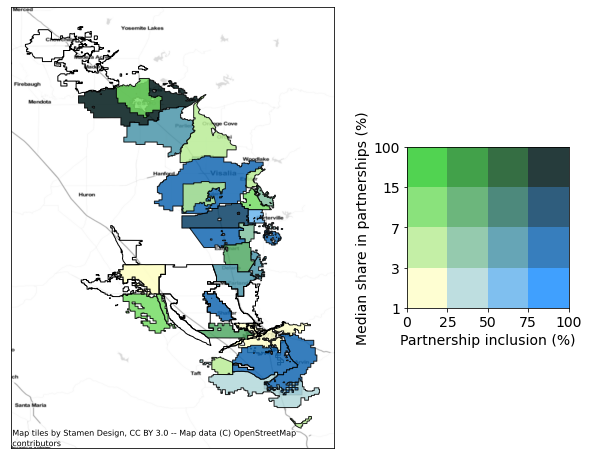

In [38]:
### test bivariate chloropleth 
alpha = 0.85

fig, axs = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'width_ratios': [0.66,0.33], 'wspace':0.3})
ax = axs[0]

### plot fraction inclusion for each district
def get_bivariate_chloropleth_color(district):
    d = 'share_' + district
    try:
#         frac = np.mean(df_shares['share_'+d] > 0)
        count = 0
        stop = False
        for inclusion_bound in inclusion_bounds:
            for share_bound in share_bounds:
                if (not stop) and (np.mean(df_shares[d] > 0) < inclusion_bound):
                    if (not stop) and (df_shares[d].loc[df_shares[d] > 0].mean() < share_bound):
                        color = colorlist[count]
                        stop = True
                count += 1
    except:
        color = 'none'
        
    return color


    
ags['median_share'] = [get_median_share(d) for d in ags['district']]
ags['color_bivariate'] = [get_bivariate_chloropleth_color(d) for d in ags['district']]

### first plot districts with non-zero participation, except COF & TUL
condition = np.logical_and(ags['color_bivariate'] != 'none', [d not in ('COF', 'TUL') for d in ags['district']])
ags.loc[condition, :].plot('median_share', ax=ax, color=ags.loc[condition, 'color_bivariate'], edgecolor='k', alpha=alpha, legend=True)
### now plot COF & TUL, which are overlapping and need to be on top
condition = np.logical_and(ags['color_bivariate'] != 'none', [d in ('COF', 'TUL') for d in ags['district']])
ags.loc[condition, :].plot('median_share', ax=ax, color=ags.loc[condition, 'color_bivariate'], edgecolor='k', alpha=alpha, legend=True)
### lastly, plot districts with zero participation, with no color but outlined in black
condition = ags['color_bivariate'] == 'none'
ags.loc[condition, :].plot('median_share', ax=ax, color=ags.loc[condition, 'color_bivariate'], edgecolor='k', legend=True)

### add basemap
cx.add_basemap(ax = ax, crs=ags.crs, source=cx.providers.Stamen.TonerLite)
ax.set_xticks([])
ax.set_yticks([])

### add color grid legend
ax = axs[1]
ax.set_aspect('equal', adjustable='box')
count = 0
for i,inclusion_bound in enumerate(inclusion_bounds):
    for j,share_bound in enumerate(share_bounds):
        shareboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(shareboxes, facecolor=colorlist[count], alpha=alpha)
        count += 1
        ax.add_collection(pc)

        
_=ax.set_xlim([0,len(share_bounds)])
_=ax.set_ylim([0,len(inclusion_bounds)])
_=ax.set_xticks(list(np.arange(0, len(inclusion_bounds)+1)), [0]+[int(b*100) for b in inclusion_bounds], fontsize='14')
_=ax.set_xlabel('Partnership inclusion (%)', fontsize='14')
_=ax.set_yticks(list(np.arange(0, len(share_bounds)+1)), [1]+[int(b*100) for b in share_bounds], fontsize='14')
_=ax.set_ylabel('Median share in partnerships (%)', fontsize='14')

plt.savefig(f'{fig_dir}district_share_distributions_bivariateChloropleth.png', bbox_inches='tight', dpi=300)


In [39]:
### patches plot, showing shares in different solutions. use custom scale
vmax_cwg = 32
cmap = cm.get_cmap('RdYlBu')
oldcolors = cmap(np.linspace(0., 1, 5))
# cmap = cm.get_cmap('viridis_r')
# oldcolors = cmap(np.linspace(0, 1, 6))
newcolors = cmap(np.linspace(0, 1, 2560))
breaks = [int(2560 * b) for b in [0, 2/32, 4/32, 8/32, 16/32, 1]]
for i , b in enumerate(breaks[:-1]):
    newcolors[b:breaks[i+1]] = oldcolors[i]
cmap_class_cwg = ListedColormap(newcolors)
mappable_cwg = cm.ScalarMappable(cmap=cmap_class_cwg)

# ### separate cmap class with even intervals for colorbar
breaks_even = [int(2560 * b) for b in [0, 1/5, 2/5, 3/5, 4/5, 1]]
newcolors_even = cmap(np.linspace(0, 1, 2560))
for i , b in enumerate(breaks_even[:-1]):
    newcolors_even[b:b+10] = [0,0,0,1]
    newcolors_even[b+10:breaks_even[i+1]] = oldcolors[i]
cmap_class_even_cwg = ListedColormap(newcolors_even)
mappable_even_cwg = cm.ScalarMappable(cmap=cmap_class_even_cwg)



### patches plot, showing shares in different solutions. use custom scale
vmax_cog = 1000
cmap = cm.get_cmap('RdYlBu_r')
oldcolors = cmap(np.linspace(0., 1, 5))
# cmap = cm.get_cmap('viridis_r')
# oldcolors = cmap(np.linspace(0, 1, 6))
newcolors = cmap(np.linspace(0, 1, 2560))
breaks = [int(2560 * b) for b in [0, 2/32, 4/32, 8/32, 16/32, 1]]
for i , b in enumerate(breaks[:-1]):
    newcolors[b:breaks[i+1]] = oldcolors[i]
cmap_class_cog = ListedColormap(newcolors)
mappable_cog = cm.ScalarMappable(cmap=cmap_class_cog)

# ### separate cmap class with even intervals for colorbar
breaks_even = [int(2560 * b) for b in [0, 1/5, 2/5, 3/5, 4/5, 1]]
newcolors_even = cmap(np.linspace(0, 1, 2560))
for i , b in enumerate(breaks_even[:-1]):
    newcolors_even[b:b+10] = [0,0,0,1]
    newcolors_even[b+10:breaks_even[i+1]] = oldcolors[i]
cmap_class_even_cog = ListedColormap(newcolors_even)
mappable_even_cog = cm.ScalarMappable(cmap=cmap_class_even_cog)



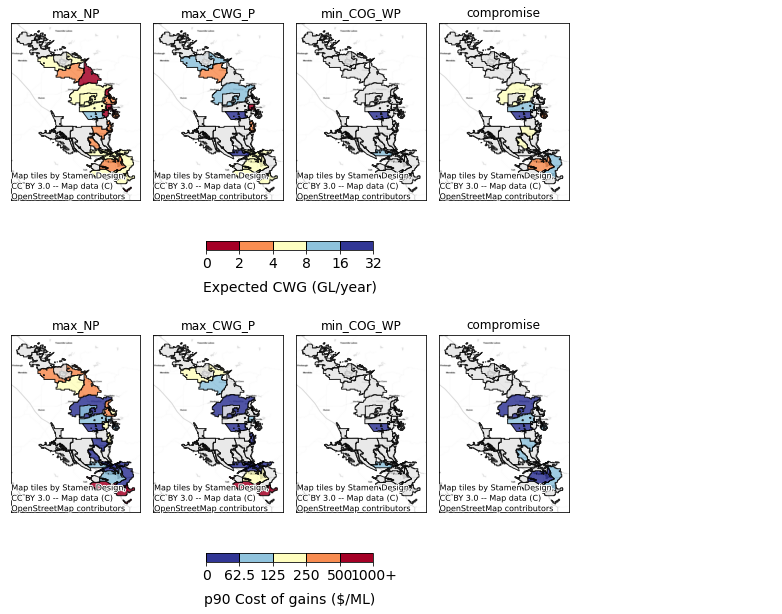

In [40]:
### cwg-colored maps for 4 example partnerships
fig = plt.figure(figsize=(10,11))
gs = gridspec.GridSpec(nrows=4, ncols=4, wspace=0.1, height_ratios=[4,1,4,1])
for count, soln in enumerate(solns):
    ax0 = fig.add_subplot(gs[0, count])
    results_soln = results.loc[results['label'] == soln]
    
    sharecols = [c for c in results_soln.columns if 'share' in c]
    districts = [c.split('_')[1] for c in sharecols]
    partners = [c.split('_')[1] for c in sharecols if results_soln[c].iloc[0] > 0]
    shares = [results_soln[f'share_{c}'].iloc[0] for c in districts]
    share_dict = {k: v for k,v in zip(districts, shares)}
    
    ### get shares for districts in gpd
    def get_share(d):
        try:
            share = share_dict[d]
        except:
            share = 0
        return share
            
    ags['share'] = [get_share(d) for d in ags['district']]
    
    with h5py.File('../results/WCU_results_s2/results.hdf5', 'r') as f:
        mc_soln = f[soln][...].transpose()
        mc_baseline = f[baseline][...].transpose()
        df_mc = pd.DataFrame(mc_soln - mc_baseline, index = ['mc' + mc for mc in f[soln].attrs['colnames']], columns = f[soln].attrs['rownames'])

    ## filter for cwg
    cap = 1000
    df_mc = df_mc.loc[:, [f'{d}_avg_captured_water' for d in districts]] * kaf_to_gl
    df_mc.columns = [f'{d}_cwg' for d in districts]
    
    ### get cost of gains in each MC sample for each partner
    project = projects[results_soln['proj'].iloc[0]]
    annual_debt_payment = annual_debt_payment_dict[project]
    partner_shares = [results_soln[f'share_{d}'].iloc[0] for d in partners]
    for i,d in enumerate(partners):
        df_mc[f'{d}_cog'] = (annual_debt_payment * partner_shares[i]) / df_mc[f'{d}_cwg'] / 1000
        df_mc[f'{d}_cog'].loc[df_mc[f'{d}_cog'] > cap] = cap
        df_mc[f'{d}_cog'].loc[df_mc[f'{d}_cog'] < 0] = cap
    
    ### map MC district results to map color
    def get_E_cwg(d):
        try:
            E_cwg = df_mc[f'{d}_cwg'].mean()
#             if ags['share'].loc[ags['district'] == d].values[0] > 0:
#                 print(d, E_cwg)
        except:
            E_cwg = 0
        return E_cwg
    ags['E_cwg'] = [get_E_cwg(d) for d in ags['district']]
    vmax = 32
    ags['E_cwg_color'] = [cmap_class_cwg(v / vmax_cwg) for v in ags['E_cwg']]
    
    ### first, plot districts with zero participation except COF&TUL, with no color but outlined in black
    condition = np.logical_and(ags['share'] == 0, [d not in ('COF', 'TUL') for d in ags['district']])
    ags.loc[condition, :].plot('E_cwg', ax=ax0, color='0.9', edgecolor='k', alpha=alpha)
    ### now plot districts with non-zero participation, except COF & TUL
    condition = np.logical_and(ags['share'] > 0, [d not in ('COF', 'TUL') for d in ags['district']])
    ags.loc[condition, :].plot('E_cwg', ax=ax0, color=ags.loc[condition, 'E_cwg_color'], edgecolor='k', alpha=alpha)
    ### lastly plot COF & TUL, which are overlapping and need to be on top
    condition = np.logical_and(ags['share'] == 0, [d in ('COF', 'TUL') for d in ags['district']])
    ags.loc[condition, :].plot('E_cwg', ax=ax0, color='0.9', edgecolor='k', alpha=alpha)
    ### now plot districts with non-zero participation, except COF & TUL
    condition = np.logical_and(ags['share'] > 0, [d in ('COF', 'TUL') for d in ags['district']])
    ags.loc[condition, :].plot('E_cwg', ax=ax0, color=ags.loc[condition, 'E_cwg_color'], edgecolor='k', alpha=alpha)

    ### basemap
    cx.add_basemap(ax = ax0, crs=ags.crs, source=cx.providers.Stamen.TonerLite)

    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title(label_dict[soln])
    
    
    ### map MC district COG to  color
    ax0 = fig.add_subplot(gs[2, count])
    def get_p90_cog(d):
        try:
            p90_cog = np.quantile(df_mc[f'{d}_cog'], 0.9)
#             if ags['share'].loc[ags['district'] == d].values[0] > 0:
#                 print(d, p90_cog)
        except:
            p90_cog = 0
        return p90_cog
    
    ags['p90_cog'] = [get_p90_cog(d) for d in ags['district']]
    vmax = 1000
    ags['p90_cog_color'] = [cmap_class_cog(v / vmax) for v in ags['p90_cog']]
    
    ### first, plot districts with zero participation except COF&TUL, with no color but outlined in black
    condition = np.logical_and(ags['share'] == 0, [d not in ('COF', 'TUL') for d in ags['district']])
    ags.loc[condition, :].plot('p90_cog', ax=ax0, color='0.9', edgecolor='k', alpha=alpha)
    ### now plot districts with non-zero participation, except COF & TUL
    condition = np.logical_and(ags['share'] > 0, [d not in ('COF', 'TUL') for d in ags['district']])
    ags.loc[condition, :].plot('p90_cog', ax=ax0, color=ags.loc[condition, 'p90_cog_color'], edgecolor='k', alpha=alpha)
    ### lastly plot COF & TUL, which are overlapping and need to be on top
    condition = np.logical_and(ags['share'] == 0, [d in ('COF', 'TUL') for d in ags['district']])
    ags.loc[condition, :].plot('p90_cog', ax=ax0, color='0.9', edgecolor='k', alpha=alpha)
    ### now plot districts with non-zero participation, except COF & TUL
    condition = np.logical_and(ags['share'] > 0, [d in ('COF', 'TUL') for d in ags['district']])
    ags.loc[condition, :].plot('p90_cog', ax=ax0, color=ags.loc[condition, 'p90_cog_color'], edgecolor='k', alpha=alpha)

    ### basemap
    cx.add_basemap(ax = ax0, crs=ags.crs, source=cx.providers.Stamen.TonerLite)

    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.set_title(label_dict[soln])
    
    
### add colorbar 
ax2 = fig.add_subplot(gs[1, :])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
# cb = plt.colorbar(mappable_even_cwg, ax=ax2, ticks=[1/10,3/10,5/10,7/10,9/10], shrink=0.5, orientation='horizontal', fraction=1)
# _ = cb.ax.set_xticklabels(['0-2', '2-4','4-8','8-16','16-32',], fontsize=fontsize)
cb = plt.colorbar(mappable_even_cwg, ax=ax2, ticks=[0,.2,.4,.6,.8,1], shrink=0.3, orientation='horizontal', fraction=1)
_ = cb.ax.set_xticklabels([0,2,4,8,16,32], fontsize=fontsize)
_ = cb.set_label('Expected CWG (GL/year)', fontsize=fontsize, labelpad=10)

### add colorbar 
ax2 = fig.add_subplot(gs[3, :])
ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
# cb = plt.colorbar(mappable_even_cog, ax=ax2, ticks=[1/10,3/10,5/10,7/10,9/10], shrink=0.5, orientation='horizontal', fraction=1)
# _ = cb.ax.set_xticklabels(['0-62.5', '62.5-125', '125-250','250-500','500-1000+',], fontsize=fontsize)
cb = plt.colorbar(mappable_even_cog, ax=ax2, ticks=[0,.2,.4,.6,.8,1], shrink=0.3, orientation='horizontal', fraction=1)
_ = cb.ax.set_xticklabels([0, 62.5, 125, 250, 500, '1000+'], fontsize=fontsize)
_ = cb.set_label('p90 Cost of gains ($/ML)', fontsize=fontsize, labelpad=10)
    

plt.savefig(f'{fig_dir}exPartnership_cwg_cog.jpg', bbox_inches='tight', dpi=300)


### clustering district attributes

In [26]:
import glob
import json
files = glob.glob('../calfews_src/districts/*')
print(files)

['../calfews_src/districts/TLB_properties.json', '../calfews_src/districts/TJC_properties.json', '../calfews_src/districts/PRT_properties.json', '../calfews_src/districts/THC_properties.json', '../calfews_src/districts/SAU_properties.json', '../calfews_src/districts/LND_properties.json', '../calfews_src/districts/SSJ_properties.json', '../calfews_src/districts/SOC_properties.json', '../calfews_src/districts/KCWA_properties.json', '../calfews_src/districts/CNS_properties.json', '../calfews_src/districts/DLE_properties.json', '../calfews_src/districts/EXE_properties.json', '../calfews_src/districts/OKR_properties.json', '../calfews_src/districts/KRT_properties.json', '../calfews_src/districts/TUL_properties.json', '../calfews_src/districts/DLR_properties.json', '../calfews_src/districts/OTL_properties.json', '../calfews_src/districts/LDS_properties.json', '../calfews_src/districts/SOB_properties.json', '../calfews_src/districts/BVA_properties.json', '../calfews_src/districts/COF_properti

In [79]:
### first get list of all possible attributes, looping over districts
attrlist = []
for f in files[:1]:
    ddict = json.load(open(f))
#     print(ddict)
#     print()


leiu_participants = []

def get_district_attrs(d, leiu_participants):
    ddict = json.load(open(f'../calfews_src/districts/{d}_properties.json'))
    
    attrs = {}
    for k,v in ddict.items():
        ### turnouts
        if k == 'turnout_list':
            for turnout in v:
                attrs[f'turnout_{turnout}'] = 1
    
        ### water contracts & rights
        elif k == 'project_contract':
            for contract, amt in v.items():
                if amt > 0:
                    attrs[f'contract_{contract}'] = amt
        elif k == 'rights':
            for right, rightdict in v.items():
                if rightdict['capacity'] > 0:
                    attrs[f'right_{right}'] = rightdict['capacity']
        
        ### water district service
        elif k == 'service':
            for service, amt in v.items():
                attrs[f'service_{service}'] = amt
        
        ### recharge time decline
        elif k == 'recharge_decline':
            attrs[f'{k}_1'] = v[1]
            attrs[f'{k}_2'] = v[1] * v[2]
            attrs[f'{k}_3'] = v[1] * v[2] * v[3]
            attrs[f'{k}_12'] = v[1] * v[2] * v[3] * v[4] * v[5] * v[6] * v[7] * v[8] * v[9] * v[10] * v[11] * v[12]
            
        ### urban profile
        elif k == 'urban_profile':
            attrs[f'{k}_min'] = np.min(v)
            attrs[f'{k}_max'] = np.max(v)
            
        ### other single attributes
        elif k in ['in_leiu_banking', 'leiu_recovery', 'in_district_direct_recharge', 'in_district_storage',
                   'loss_rate', 'recovery_fraction', 'surface_water_sa', 'must_fill', 'seasonal_connection',
                   'seepage', 'inleiuhaircut', 'zone', 'MDD']:
            attrs[k] = v
        
        ### for inleiu bank participants, we actually want to add this as attribute for participants, not bank itself
        elif k == 'participant_list':
            leiu_participants += v
        
        ### attributes to ignore
        elif k in ['contract_list', 'crop_list', 'acreage', 'inleiucap', 'leiu_ownership']:
            pass
        
        else:
            print(f'rule undefined: {k}')
            print(v)
        
    ### now deal with crop list and acreage jointly
    try:
        for wyt, acreages in ddict['acreage'].items():
            acreage_total = 0.
            for ic, crop in enumerate(ddict['crop_list']):
                if crop != 'idle':
                    acreage_total += acreages[ic]
                if wyt == 'AN':
                    attrs[f'acreage_{crop}'] = acreages[ic]
            attrs[f'acreage_{wyt}'] = acreage_total
    except:
        pass
    
    return attrs, leiu_participants
    
    
district_attrs = {}
for d in districts:
     district_attrs[d], leiu_participants = get_district_attrs(d, leiu_participants)

### after cycling through all districts, go back and add attribute for leiu participation
for d in set(leiu_participants):
    if d in ['MET', 'CCH', 'CTL']:
        try:
            district_attrs['SOC']['leiu_partnerships'] += np.sum([1 for dd in leiu_participants if dd == d])
        except:
            district_attrs['SOC']['leiu_partnerships'] = np.sum([1 for dd in leiu_participants if dd == d])
    elif d in ['OXV', 'OFK']:
        pass
    else:
        district_attrs[d]['leiu_partnerships'] = np.sum([1 for dd in leiu_participants if dd == d])

### now loop through banks and get participation 
def get_bank_participants(bank, district_attrs):
    bdict = json.load(open(f'../calfews_src/banks/{bank}_properties.json'))
    for d in bdict['participant_list']:
        if d in ['MET', 'CCH', 'CTL']:
            d = 'SOC'
        if d in ['KCWA', 'WON']:
            pass
        else:
            try:
                district_attrs[d]['bank_partnerships'] += 1
            except:
                district_attrs[d]['bank_partnerships'] = 1
    return district_attrs

for bank in ['KWB']:
    district_attrs = get_bank_participants(bank, district_attrs)
    
print(district_attrs['ID4'])

##### Next steps:
#####    1. check if WON partners included in experiment, and if so split out
#####    2. add other banks
#####    3. add other bank metrics eg recharge capacity, ownership
#####    4. acct for changes in set_regulations - e.g. KWB has zero recovery in properties file, but gets reset in simulation

{'turnout_fkc': 1, 'turnout_xvc': 1, 'turnout_knr': 1, 'in_leiu_banking': False, 'leiu_recovery': 0.0, 'in_district_direct_recharge': 208.0, 'in_district_storage': 0.41, 'loss_rate': 0.1, 'recovery_fraction': 1.0, 'surface_water_sa': 1.0, 'must_fill': 1, 'seasonal_connection': 1.0, 'seepage': 1.25, 'inleiuhaircut': 0.9, 'recharge_decline_1': 0.94, 'recharge_decline_2': 0.8271999999999999, 'recharge_decline_3': 0.7279359999999999, 'recharge_decline_12': 0.5254179484952111, 'contract_tableA': 0.02044916, 'zone': 'zone15', 'MDD': 32.23, 'urban_profile_min': 0.05525, 'urban_profile_max': 0.1069, 'acreage_W': 3.295, 'acreage_alfalfa': 1.132, 'acreage_corn': 0.724, 'acreage_cotton': 0.0, 'acreage_onion': 0.008, 'acreage_pasture': 0.033, 'acreage_safflower': 0.242, 'acreage_grain': 1.156, 'acreage_idle': 62.105, 'acreage_AN': 3.295, 'acreage_BN': 3.295, 'acreage_D': 3.295, 'acreage_C': 3.295, 'bank_partnerships': 1}
